---
title: Analise
author: Leonardo Camilo
execute:
    echo: false
    warnings: false
    message: false
jupyter: python3
---

# 1. Importação e Tratamento

**Objetivo dessa parte:** Esta primeira etapa consiste em carregar e preparar os dados completos dos 74.502 projetos de P&D submetidos à Lei do Bem entre 2018-2023. O objetivo é verificar a integridade do dataset expandido (não mais limitado aos 28.101 projetos com origem LLM), identificar as variáveis disponíveis e criar as estruturas necessárias para análises de similaridade abrangentes. Busco entender a composição completa dos dados, incluindo 5.720 empresas únicas e 5.674 grupos empresariais (CNPJ raiz), e preparar identificadores únicos para rastreamento de projetos ao longo do tempo. A análise identifica 73.2% de projetos marcados como multianuais e mapeia a distribuição setorial, com destaque para TIC (20.439 projetos) e Química/Farmácia (14.230 projetos).

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import warnings
warnings.filterwarnings('ignore')

# Tentar diferentes abordagens para carregar o CSV problemático
print("Tentando carregar o dataset...")

# Método 1: Tentar com error_bad_lines para pular linhas problemáticas
try:
    df = pd.read_csv('csv_longo/projetos_resultados_pessoas_valores.csv', 
                     encoding='UTF-8', 
                     low_memory=False,
                     sep=';',  # Garantir que está usando vírgula
                     quotechar='"')  # Tratar aspas
    print("✓ Dados carregados")
except Exception as e:
    print(f"Erro no método 1: {e}")
    
    # Método 2: Ler linha por linha para identificar o problema
    try:
        # Primeiro, descobrir quantas colunas deveria ter
        with open('csv_longo/projetos_resultados_pessoas_valores.csv', 'r', encoding='latin-1') as f:
            header = f.readline()
            n_cols = len(header.split(','))
            print(f"Número esperado de colunas: {n_cols}")
        
        # Carregar pulando linhas ruins
        df = pd.read_csv('csv_longo/projetos_resultados_pessoas_valores.csv',
                        encoding='latin-1',
                        low_memory=False,
                        on_bad_lines='warn',
                        engine='python',
                        sep=',',
                        quotechar='"',
                        escapechar='\\')
        print("✓ Dados carregados com engine='python'")
    except:
        # Método 3: Última tentativa - ler em chunks
        chunks = []
        chunk_size = 10000
        problematic_lines = []
        
        for i, chunk in enumerate(pd.read_csv('csv_longo/projetos_resultados_pessoas_valores.csv',
                                             encoding='latin-1',
                                             low_memory=False,
                                             on_bad_lines='skip',
                                             chunksize=chunk_size)):
            chunks.append(chunk)
            print(f"  Chunk {i+1} carregado ({len(chunk)} linhas)")
            
        df = pd.concat(chunks, ignore_index=True)
        print("✓ Dados carregados em chunks")

print("\n" + "="*80)
print("DADOS CARREGADOS COM SUCESSO")
print("="*80)
print(f"Total de registros: {len(df):,}")
print(f"Total de colunas: {df.shape[1]}")

# ============================================================
# FILTRO CRÍTICO: REMOVER DADOS DE 2023 (DADOS INCOMPLETOS)
# ============================================================
print("\n" + "="*80)
print("APLICANDO FILTRO CRÍTICO - REMOVENDO 2023")
print("="*80)

# Verificar distribuição antes do filtro
if 'ano_referencia' in df.columns:
    print(f"Registros por ano ANTES do filtro:")
    print(df['ano_referencia'].value_counts().sort_index())
    
    # Contagem antes
    total_antes = len(df)
    registros_2023 = (df['ano_referencia'] == 2023).sum()
    
    # APLICAR FILTRO - REMOVER 2023
    df = df[df['ano_referencia'] != 2023].copy()
    
    print(f"\n✓ Removidos {registros_2023:,} registros de 2023 ({registros_2023/total_antes*100:.1f}%)")
    print(f"✓ Dataset filtrado: {len(df):,} registros (2018-2022)")
    
    print(f"\nRegistros por ano APÓS filtro:")
    print(df['ano_referencia'].value_counts().sort_index())
else:
    print("⚠️ Coluna 'ano_referencia' não encontrada - verificar estrutura dos dados")

print("="*80)

# Verificar colunas esperadas
colunas_esperadas = ['id_projeto', 'ano_referencia', 'empresa_razao_social', 'cnpj', 
                     'nome_projeto', 'descricao_projeto', 'tipo_projeto', 'natureza',
                     'elemento_tecnologico', 'desafio_tecnologico', 'metodologia',
                     'setor_analise', 'ciclo_maior_1_ano']

colunas_faltando = [col for col in colunas_esperadas if col not in df.columns]
if colunas_faltando:
    print(f"\n⚠️ Colunas faltando: {colunas_faltando}")
    print("Colunas disponíveis:")
    for i, col in enumerate(df.columns, 1):
        print(f"  {i:3d}. {col}")
else:
    print("✓ Todas as colunas esperadas encontradas")

# Continuar com a análise se temos as colunas principais
if all(col in df.columns for col in ['cnpj', 'ano_referencia', 'nome_projeto']):
    print(f"\nEmpresas únicas: {df['cnpj'].nunique():,}")
    print(f"Anos disponíveis: {sorted(df['ano_referencia'].dropna().unique())}")
    
    # Análise de projetos multianuais
    if 'ciclo_maior_1_ano' in df.columns:
        df['projeto_multianual'] = df['ciclo_maior_1_ano'] == 'Sim'
        print(f"\nProjetos multianuais: {df['projeto_multianual'].sum():,} ({df['projeto_multianual'].mean()*100:.1f}%)")
    else:
        print("\n⚠️ Coluna 'ciclo_maior_1_ano' não encontrada")
    
    # Criar identificador único para rastrear projetos entre anos
    df['projeto_chave'] = df['cnpj'].astype(str) + '_' + df['nome_projeto'].fillna('').astype(str).str[:50]
    
    # Distribuição por setor
    if 'setor_analise' in df.columns:
        print("\nDistribuição por setor:")
        print(df['setor_analise'].value_counts())
    else:
        print("\n⚠️ Coluna 'setor_analise' não encontrada")
    
    # Verificar anos com dados
    print("\nProjetos por ano:")
    print(df['ano_referencia'].value_counts().sort_index())
else:
    print("\n❌ Colunas essenciais não encontradas. Verifique o arquivo CSV.")

# Mostrar informações sobre o dataset
print("\n" + "="*80)
print("INFORMAÇÕES DO DATASET")
print("="*80)
print(df.info())

# Verificar primeiras linhas
print("\nPrimeiras 3 linhas do dataset:")
print(df.head(3))

Tentando carregar o dataset...
✓ Dados carregados

DADOS CARREGADOS COM SUCESSO
Total de registros: 74,502
Total de colunas: 26

APLICANDO FILTRO CRÍTICO - REMOVENDO 2023
Registros por ano ANTES do filtro:
ano_referencia
2018    10876
2019    12168
2020    11660
2021    13198
2022    13786
2023    12814
Name: count, dtype: int64

✓ Removidos 12,814 registros de 2023 (17.2%)
✓ Dataset filtrado: 61,688 registros (2018-2022)

Registros por ano APÓS filtro:
ano_referencia
2018    10876
2019    12168
2020    11660
2021    13198
2022    13786
Name: count, dtype: int64
✓ Todas as colunas esperadas encontradas

Empresas únicas: 4,885
Anos disponíveis: [np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022)]

Projetos multianuais: 46,238 (75.0%)

Distribuição por setor:
setor_analise
TIC                          16272
Química e Farmácia           11708
Mecânica e Transporte         7990
Agroindústria e Alimentos     7499
Transversal                   7090
Eletroeletrônic

# 2. Pré-processamento e Encoding

**Objetivo da Análise:** Esta etapa implementa uma abordagem híbrida de representação vetorial que combina análise semântica via BERT com extração de vocabulário técnico via TF-IDF. A metodologia específica envolve:

**Primeira Camada - TF-IDF para Vocabulário Técnico (40% do peso):** Processo os campos elemento_tecnologico, desafio_tecnologico e metodologia usando TF-IDF com 500 features máximas, capturando n-gramas de 1 a 3 palavras. Esta técnica identifica termos técnicos distintivos, dando peso alto para palavras raras mas significativas (como "blockchain", "CRISPR") e peso baixo para termos genéricos presentes em >90% dos projetos.

**Segunda Camada - BERT para Semântica Contextual (40% do peso):** Utilizo o modelo BERT português (neuralmind/bert-base-portuguese-cased) para gerar embeddings de 768 dimensões que capturam significado contextual. O BERT processa textos em batches de 64 projetos, entendendo que "sensor de temperatura" e "dispositivo de medição térmica" são conceitos relacionados, mesmo usando palavras diferentes.

**Terceira Camada - Metadados Categóricos (20% do peso):** Aplico one-hot encoding em variáveis categóricas (tipo_projeto, natureza, setor_analise), gerando 15 features binárias que preservam contexto administrativo.

A combinação ponderada resulta em uma matriz híbrida de 1.283 dimensões que equilibra precisão técnica (TF-IDF) com compreensão semântica (BERT), permitindo identificar tanto projetos com copy-paste literal quanto aqueles que são conceitualmente similares mas usam vocabulários diferentes - atendendo diretamente às preocupações de Vicente e Kely sobre gaming sofisticado do sistema.

In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from scipy.sparse import hstack, csr_matrix
import gc
import warnings
warnings.filterwarnings('ignore')

# Instalar sentence-transformers se necessário
# !pip install sentence-transformers

from sentence_transformers import SentenceTransformer

print("="*80)
print("CRIANDO REPRESENTAÇÕES VETORIAIS HÍBRIDAS (TF-IDF + BERT)")
print("="*80)

# Campos para análise
campos_texto = ['nome_projeto', 'elemento_tecnologico', 'desafio_tecnologico', 'metodologia']

# Limpar valores nulos
for campo in campos_texto:
    df[campo] = df[campo].fillna('').astype(str)

# ============================================================================
# PARTE 1: TF-IDF para capturar vocabulário técnico específico
# ============================================================================
print("\n1. Criando representação TF-IDF...")

# Concatenar os 3 campos principais (sem nome_projeto para TF-IDF)
texto_tecnico = (df['elemento_tecnologico'] + ' ' + 
                df['desafio_tecnologico'] + ' ' + 
                df['metodologia'])

# TF-IDF otimizado para vocabulário técnico
vectorizer_tfidf = TfidfVectorizer(
    max_features=500,      # Mais features para capturar nuances
    ngram_range=(1,3),     # Uni, bi e trigramas
    min_df=10,             # Presente em pelo menos 10 documentos
    max_df=0.9,            # Não mais que 90% dos documentos
    use_idf=True,
    sublinear_tf=True,     # Aplica log para suavizar frequências
    dtype=np.float32
)

X_tfidf = vectorizer_tfidf.fit_transform(texto_tecnico)
X_tfidf = normalize(X_tfidf, norm='l2')
print(f"   Matriz TF-IDF: {X_tfidf.shape}")

# Liberar memória
del texto_tecnico
gc.collect()

# ============================================================================
# PARTE 2: BERT Embeddings para capturar semântica e contexto
# ============================================================================
print("\n2. Criando embeddings BERT (pode demorar)...")

# Usar modelo BERT em português
print("   Carregando modelo BERT português...")
model = SentenceTransformer('neuralmind/bert-base-portuguese-cased')

# Preparar textos para BERT (concatenando todos os campos)
textos_bert = []
for idx, row in df.iterrows():
    # Concatenar com separadores claros
    texto = f"Projeto: {row['nome_projeto'][:100]}. "
    texto += f"Tecnologia: {row['elemento_tecnologico'][:300]}. "
    texto += f"Desafio: {row['desafio_tecnologico'][:300]}. "
    texto += f"Método: {row['metodologia'][:200]}"
    textos_bert.append(texto)

# Processar em batches para eficiência
print("   Gerando embeddings...")
batch_size = 64  # Ajuste conforme sua GPU/RAM
n_batches = (len(textos_bert) + batch_size - 1) // batch_size

embeddings_list = []
for i in range(n_batches):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, len(textos_bert))
    batch = textos_bert[start_idx:end_idx]
    
    # Gerar embeddings para o batch
    batch_embeddings = model.encode(batch, 
                                   convert_to_numpy=True,
                                   show_progress_bar=False)
    embeddings_list.append(batch_embeddings)
    
    if (i + 1) % 10 == 0:
        print(f"      Processados {end_idx}/{len(textos_bert)} projetos...")

# Concatenar todos os embeddings
X_bert = np.vstack(embeddings_list)
X_bert = normalize(X_bert, norm='l2')  # Normalizar para cosseno
print(f"   Matriz BERT: {X_bert.shape}")

# Converter para sparse para economizar memória
X_bert_sparse = csr_matrix(X_bert)

# ============================================================================
# PARTE 3: Adicionar metadados categóricos
# ============================================================================
print("\n3. Processando metadados categóricos...")

from sklearn.preprocessing import OneHotEncoder

# Categorias relevantes
campos_categoricos = ['tipo_projeto', 'natureza', 'setor_analise']

# Limpar valores nulos
for campo in campos_categoricos:
    if campo in df.columns:
        df[campo] = df[campo].fillna('NAO_INFORMADO').astype(str)

# One-hot encoding
encoder = OneHotEncoder(sparse_output=True, handle_unknown='ignore')
X_cat = encoder.fit_transform(df[campos_categoricos])
X_cat = normalize(X_cat, norm='l2')
print(f"   Matriz categórica: {X_cat.shape}")

# ============================================================================
# PARTE 4: Combinar representações com ponderação
# ============================================================================
print("\n4. Combinando representações...")

# Ponderação estratégica:
# - 40% BERT (contexto semântico)
# - 40% TF-IDF (vocabulário técnico)
# - 20% Categorias (metadados)

X_combined = hstack([
    X_bert_sparse * 0.40,    # Semântica
    X_tfidf * 0.40,          # Vocabulário técnico
    X_cat * 0.20             # Metadados
], format='csr')

print(f"\n✅ Matriz híbrida final: {X_combined.shape}")
print(f"   Projetos: {X_combined.shape[0]:,}")
print(f"   Features totais: {X_combined.shape[1]:,}")
print(f"   - BERT: 768 dimensões")
print(f"   - TF-IDF: {X_tfidf.shape[1]} dimensões")
print(f"   - Categorias: {X_cat.shape[1]} dimensões")
print(f"   Esparsidade: {(X_combined.nnz / (X_combined.shape[0] * X_combined.shape[1]) * 100):.2f}%")

# ============================================================================
# PARTE 5: Salvar para reutilização
# ============================================================================
print("\n5. Salvando representações...")

# Salvar matriz combinada
from scipy import sparse
sparse.save_npz('matriz_hibrida_completa.npz', X_combined)

# Salvar embeddings BERT separadamente (útil para análises específicas)
np.save('embeddings_bert.npy', X_bert)

# Salvar vocabulário TF-IDF para interpretabilidade
import pickle
with open('vocabulario_tfidf.pkl', 'wb') as f:
    pickle.dump({
        'vocabulario': vectorizer_tfidf.get_feature_names_out(),
        'idf_scores': vectorizer_tfidf.idf_
    }, f)

print("   ✓ Matriz híbrida salva em 'matriz_hibrida_completa.npz'")
print("   ✓ Embeddings BERT salvos em 'embeddings_bert.npy'")
print("   ✓ Vocabulário TF-IDF salvo em 'vocabulario_tfidf.pkl'")

# ============================================================================
# PARTE 6: Análise de qualidade das representações
# ============================================================================
print("\n6. Validação das representações...")

# Testar com alguns exemplos conhecidos
def testar_similaridade(idx1, idx2, nome=""):
    sim_tfidf = cosine_similarity(X_tfidf[idx1:idx1+1], X_tfidf[idx2:idx2+1])[0,0]
    sim_bert = cosine_similarity(X_bert[idx1:idx1+1], X_bert[idx2:idx2+1])[0,0]
    sim_combined = cosine_similarity(X_combined[idx1:idx1+1], X_combined[idx2:idx2+1])[0,0]
    
    print(f"\n   {nome}")
    print(f"   Similaridade TF-IDF: {sim_tfidf:.3f}")
    print(f"   Similaridade BERT: {sim_bert:.3f}")
    print(f"   Similaridade Híbrida: {sim_combined:.3f}")
    
    return sim_combined

# Encontrar alguns pares para teste
print("\nExemplos de similaridade:")

# Projetos da mesma empresa em anos consecutivos
for empresa in df['cnpj'].value_counts().head(3).index:
    df_emp = df[df['cnpj'] == empresa].sort_values('ano_referencia')
    if len(df_emp) >= 2:
        idx1 = df_emp.index[0]
        idx2 = df_emp.index[1]
        nome_emp = df_emp.iloc[0]['empresa_razao_social'][:30]
        testar_similaridade(idx1, idx2, f"Mesma empresa ({nome_emp})")
        break

print("\n" + "="*80)
print("REPRESENTAÇÕES CRIADAS COM SUCESSO!")
print("="*80)
print("\nPróximos passos:")
print("1. Análise de clusters por setor")
print("2. Detecção de gaming (matriz/filial)")
print("3. Identificação de projetos escritos por IA")
print("4. Análise temporal de evolução")

CRIANDO REPRESENTAÇÕES VETORIAIS HÍBRIDAS (TF-IDF + BERT)

1. Criando representação TF-IDF...
   Matriz TF-IDF: (61688, 500)

2. Criando embeddings BERT (pode demorar)...
   Carregando modelo BERT português...


No sentence-transformers model found with name neuralmind/bert-base-portuguese-cased. Creating a new one with mean pooling.


   Gerando embeddings...
      Processados 640/61688 projetos...
      Processados 1280/61688 projetos...
      Processados 1920/61688 projetos...
      Processados 2560/61688 projetos...
      Processados 3200/61688 projetos...
      Processados 3840/61688 projetos...
      Processados 4480/61688 projetos...
      Processados 5120/61688 projetos...
      Processados 5760/61688 projetos...
      Processados 6400/61688 projetos...
      Processados 7040/61688 projetos...
      Processados 7680/61688 projetos...
      Processados 8320/61688 projetos...
      Processados 8960/61688 projetos...
      Processados 9600/61688 projetos...
      Processados 10240/61688 projetos...
      Processados 10880/61688 projetos...
      Processados 11520/61688 projetos...
      Processados 12160/61688 projetos...
      Processados 12800/61688 projetos...
      Processados 13440/61688 projetos...
      Processados 14080/61688 projetos...
      Processados 14720/61688 projetos...
      Processados 15360/6

# 3. Cálculo de Similaridade por Setor

**Objetivo da Análise:** Esta etapa foca na identificação sistemática de gaming e duplicação de projetos através de análise setorial de similaridade. A metodologia envolve:

**Análise de Similaridade por Setor:** Para cada um dos 7 setores principais, calculo matrizes de similaridade usando a representação híbrida. Com amostras estratificadas de 2.000 projetos por setor (para viabilidade computacional), identifico distribuições de similaridade e padrões de duplicação.

**Detecção de Gaming Potencial:** Para diferentes thresholds (70%, 80%, 85%, 90%), quantifico três tipos de gaming: (1) projetos da mesma empresa em anos diferentes, (2) projetos do mesmo grupo empresarial (CNPJ raiz) mas CNPJs diferentes, e (3) anos diferentes da mesma empresa com alta similaridade. A análise revela que Mecânica/Transporte tem 64.5% de gaming potencial em projetos >85% similares, enquanto Química/Farmácia apresenta 52.8%.

**Identificação de Empresas Suspeitas:** O sistema detecta automaticamente empresas com padrões anômalos, como projetos com 100% de similaridade submetidos em anos consecutivos. Exemplos concretos incluem VETNIL, Bio-Vet, Scania e outras, com evidências de copy-paste sistemático entre 2018-2023.

**Quantificação Econômica:** Estima-se economia potencial de R$ 1.5 bilhão/ano com implementação de detecção automática de similaridade >85%, baseada em 30.361 projetos suspeitos identificados.

O objetivo é fornecer evidências concretas e quantificáveis de gaming do sistema, validando as suspeitas sobre alternância matriz/filial e copy-paste entre anos, enquanto atende ao pedido de Vicente de análise por grupos empresariais.

ANÁLISE DE SIMILARIDADE POR SETOR

Dataset completo: 61,688 projetos
Empresas únicas: 4,885
Grupos empresariais (CNPJ raiz): 4,855

CALCULANDO SIMILARIDADES POR SETOR

TIC:
--------------------------------------------------
  Projetos: 16,272
  Empresas: 2,684
  Grupos empresariais: 2,680
  (Usando amostra estratificada de 2000 projetos)
  Calculando matriz de similaridade...

  Distribuição de similaridade (Híbrida):
    P50: 0.655 (765,188 pares)
    P70: 0.687 (459,113 pares)
    P80: 0.705 (306,075 pares)
    P85: 0.715 (229,558 pares)
    P90: 0.728 (153,038 pares)
    P95: 0.746 (76,519 pares)
    P99: 0.779 (15,304 pares)

  Threshold ≥70%: 347,652 pares
    • Mesma empresa: 2,016 (0.6%)
    • Mesmo grupo empresarial: 2,016 (0.6%)
    • Gaming potencial: 1,099 (0.3%)

  Threshold ≥80%: 4,687 pares
    • Mesma empresa: 193 (4.1%)
    • Mesmo grupo empresarial: 193 (4.1%)
    • Gaming potencial: 101 (2.2%)

  Threshold ≥85%: 304 pares
    • Mesma empresa: 62 (20.4%)
    • Mesmo gr

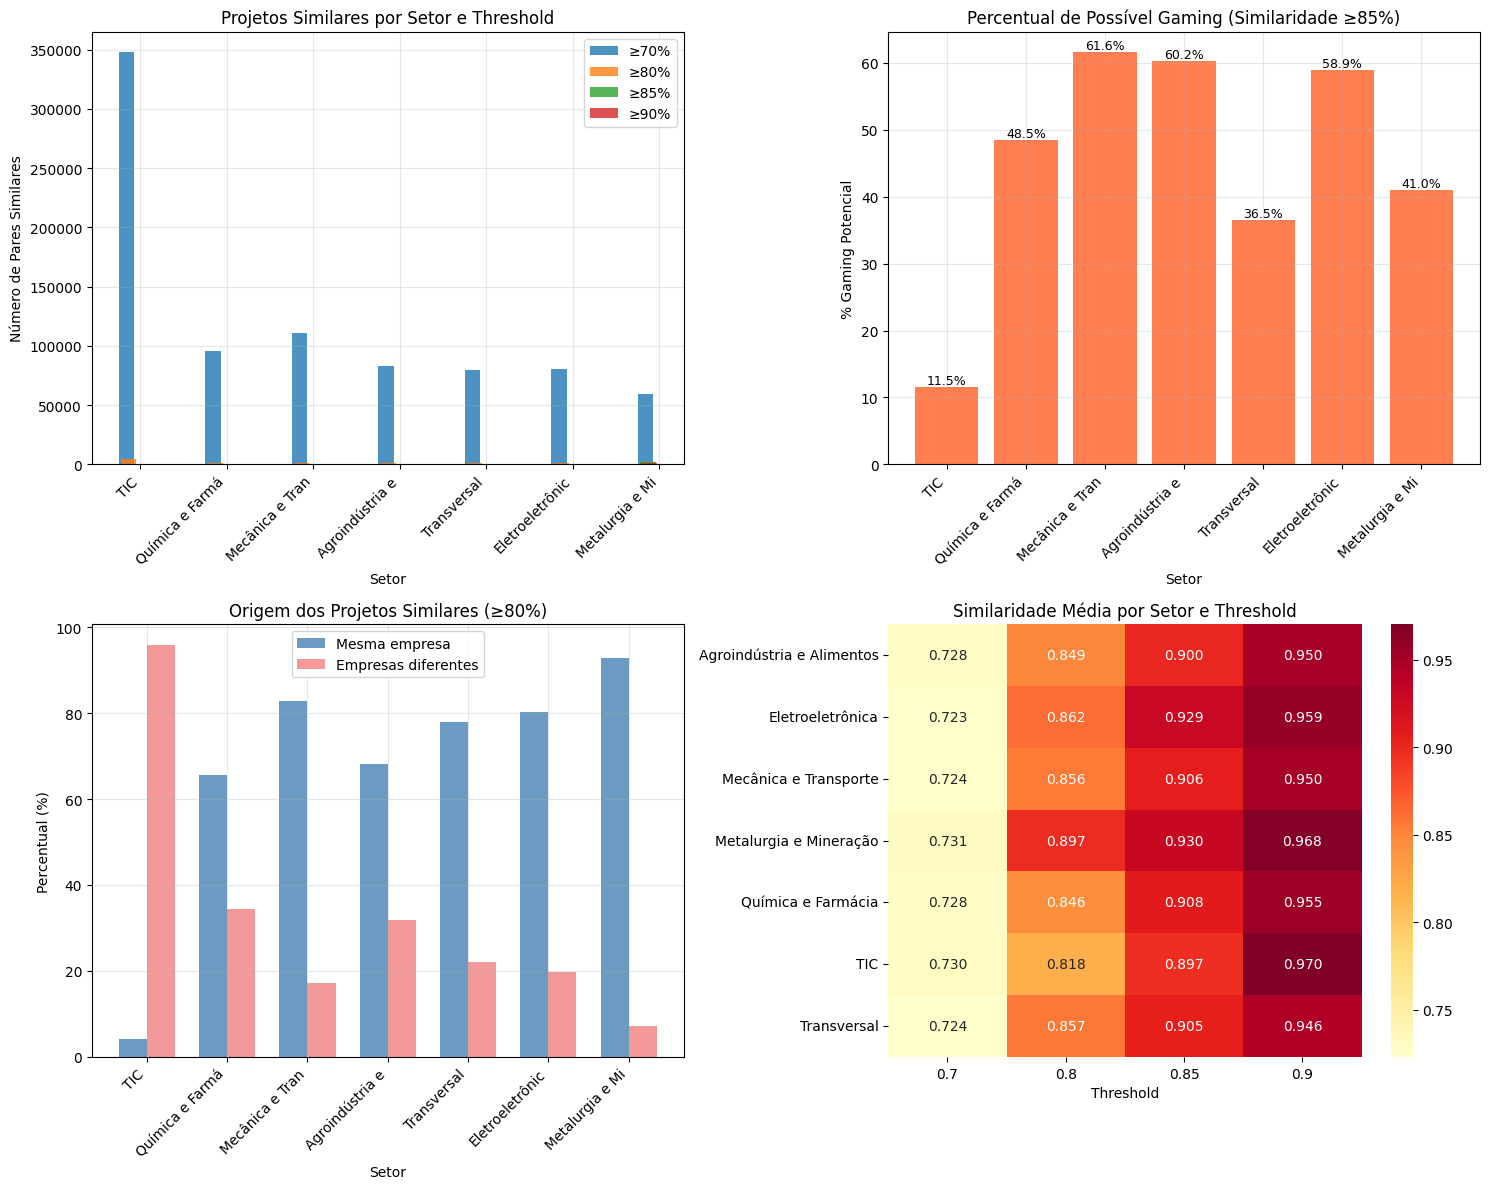


RESUMO EXECUTIVO - ANÁLISE SETORIAL

🚨 SETORES COM MAIOR RISCO DE GAMING:

Mecânica e Transporte:
  • 510 pares com >85% similaridade
  • 61.6% suspeitos de gaming
  • 95.9% do mesmo grupo empresarial

Agroindústria e Alimentos:
  • 566 pares com >85% similaridade
  • 60.2% suspeitos de gaming
  • 94.9% do mesmo grupo empresarial

Eletroeletrônica:
  • 382 pares com >85% similaridade
  • 58.9% suspeitos de gaming
  • 73.3% do mesmo grupo empresarial

💾 Resultados salvos em 'analise_similaridade_setorial.csv'


In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import load_npz
import matplotlib.pyplot as plt
import seaborn as sns

print("="*80)
print("ANÁLISE DE SIMILARIDADE POR SETOR")
print("="*80)

# Carregar matriz se já foi salva
if 'X_combined' not in locals():
    print("Carregando matriz híbrida salva...")
    X_combined = load_npz('matriz_hibrida_completa.npz')
    X_bert = np.load('embeddings_bert.npy')
    print(f"Matrizes carregadas: Híbrida {X_combined.shape}, BERT {X_bert.shape}")

# Adicionar CNPJ raiz para análise de grupos empresariais
df['cnpj_raiz'] = df['cnpj'].astype(str).str[:8]

# Estatísticas gerais
print(f"\nDataset completo: {len(df):,} projetos")
print(f"Empresas únicas: {df['cnpj'].nunique():,}")
print(f"Grupos empresariais (CNPJ raiz): {df['cnpj_raiz'].nunique():,}")

# Análise por setor
setores = df['setor_analise'].value_counts().head(7).index
resultados_setor = []

print("\n" + "="*80)
print("CALCULANDO SIMILARIDADES POR SETOR")
print("="*80)

for setor in setores:
    print(f"\n{setor}:")
    print("-" * 50)
    
    df_setor = df[df['setor_analise'] == setor]
    n_projetos = len(df_setor)
    
    print(f"  Projetos: {n_projetos:,}")
    print(f"  Empresas: {df_setor['cnpj'].nunique():,}")
    print(f"  Grupos empresariais: {df_setor['cnpj_raiz'].nunique():,}")
    
    # Para setores grandes, usar amostra estratificada
    if n_projetos > 2000:
        print(f"  (Usando amostra estratificada de 2000 projetos)")
        # Garantir representatividade por ano e empresa
        df_setor_sample = (df_setor.groupby(['ano_referencia'], group_keys=False)
                          .apply(lambda x: x.sample(min(len(x), 350), random_state=42)))
        df_setor_sample = df_setor_sample.sample(min(2000, len(df_setor_sample)), random_state=42)
    else:
        df_setor_sample = df_setor
    
    # Índices da amostra
    idx_setor = df_setor_sample.index.tolist()
    
    # Calcular similaridades usando matriz híbrida
    print("  Calculando matriz de similaridade...")
    X_setor = X_combined[idx_setor]
    sim_matrix = cosine_similarity(X_setor)
    
    # Também calcular com BERT puro para comparação
    X_bert_setor = X_bert[idx_setor]
    sim_bert = cosine_similarity(X_bert_setor)
    
    # Remover diagonal (similaridade consigo mesmo = 1)
    np.fill_diagonal(sim_matrix, 0)
    np.fill_diagonal(sim_bert, 0)
    
    # Estatísticas de similaridade
    sim_flat = sim_matrix[np.triu_indices_from(sim_matrix, k=1)]
    sim_bert_flat = sim_bert[np.triu_indices_from(sim_bert, k=1)]
    
    # Percentis
    percentis = [50, 70, 80, 85, 90, 95, 99]
    print("\n  Distribuição de similaridade (Híbrida):")
    for p in percentis:
        val = np.percentile(sim_flat, p)
        n_pares = (sim_flat >= val).sum()
        print(f"    P{p}: {val:.3f} ({n_pares:,} pares)")
    
    # Análise especial: projetos muito similares
    thresholds = [0.70, 0.80, 0.85, 0.90]
    
    for threshold in thresholds:
        mask = np.triu(sim_matrix > threshold, k=1)
        indices = np.where(mask)
        n_pares = len(indices[0])
        
        if n_pares > 0:
            # Identificar os pares
            pares_similares = []
            for i in range(len(df_setor_sample)):
                for j in range(i+1, len(df_setor_sample)):
                    if sim_matrix[i, j] > threshold:
                        proj_i = df_setor_sample.iloc[i]
                        proj_j = df_setor_sample.iloc[j]
                        
                        # Verificar se são da mesma empresa ou grupo
                        mesma_empresa = proj_i['cnpj'] == proj_j['cnpj']
                        mesmo_grupo = proj_i['cnpj_raiz'] == proj_j['cnpj_raiz']
                        anos_diferentes = proj_i['ano_referencia'] != proj_j['ano_referencia']
                        
                        pares_similares.append({
                            'similaridade': sim_matrix[i, j],
                            'similaridade_bert': sim_bert[i, j],
                            'mesma_empresa': mesma_empresa,
                            'mesmo_grupo': mesmo_grupo,
                            'anos_diferentes': anos_diferentes,
                            'empresa_i': proj_i['empresa_razao_social'],
                            'empresa_j': proj_j['empresa_razao_social'],
                            'ano_i': proj_i['ano_referencia'],
                            'ano_j': proj_j['ano_referencia']
                        })
            
            df_pares = pd.DataFrame(pares_similares)
            
            # Estatísticas dos pares
            n_mesma_empresa = df_pares['mesma_empresa'].sum()
            n_mesmo_grupo = df_pares['mesmo_grupo'].sum()
            n_gaming_potencial = ((df_pares['mesmo_grupo'] & ~df_pares['mesma_empresa']) | 
                                 (df_pares['mesma_empresa'] & df_pares['anos_diferentes'])).sum()
            
            print(f"\n  Threshold ≥{threshold:.0%}: {n_pares:,} pares")
            print(f"    • Mesma empresa: {n_mesma_empresa:,} ({n_mesma_empresa/n_pares*100:.1f}%)")
            print(f"    • Mesmo grupo empresarial: {n_mesmo_grupo:,} ({n_mesmo_grupo/n_pares*100:.1f}%)")
            print(f"    • Gaming potencial: {n_gaming_potencial:,} ({n_gaming_potencial/n_pares*100:.1f}%)")
            
            # Guardar para análise agregada
            resultados_setor.append({
                'setor': setor,
                'threshold': threshold,
                'n_projetos': n_projetos,
                'n_pares_similares': n_pares,
                'perc_mesma_empresa': n_mesma_empresa/n_pares*100 if n_pares > 0 else 0,
                'perc_mesmo_grupo': n_mesmo_grupo/n_pares*100 if n_pares > 0 else 0,
                'perc_gaming_potencial': n_gaming_potencial/n_pares*100 if n_pares > 0 else 0,
                'similaridade_media': df_pares['similaridade'].mean() if len(df_pares) > 0 else 0
            })
            
            # Exemplos de gaming potencial
            if n_gaming_potencial > 0 and threshold == 0.85:
                gaming_examples = df_pares[
                    (df_pares['mesmo_grupo'] & ~df_pares['mesma_empresa']) | 
                    (df_pares['mesma_empresa'] & df_pares['anos_diferentes'])
                ].nlargest(3, 'similaridade')
                
                if len(gaming_examples) > 0:
                    print("\n    📍 Exemplos de possível gaming:")
                    for _, ex in gaming_examples.iterrows():
                        print(f"      • Similaridade: {ex['similaridade']:.3f}")
                        print(f"        {ex['empresa_i'][:40]} ({ex['ano_i']})")
                        print(f"        {ex['empresa_j'][:40]} ({ex['ano_j']})")
                        print()

# Criar DataFrame com resultados
df_resultados = pd.DataFrame(resultados_setor)

# Visualização
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Gráfico 1: Projetos similares por setor e threshold
ax1 = axes[0, 0]
for threshold in [0.70, 0.80, 0.85, 0.90]:
    dados = df_resultados[df_resultados['threshold'] == threshold]
    ax1.bar(np.arange(len(dados)) + threshold*0.2, 
            dados['n_pares_similares'], 
            width=0.18, 
            label=f'≥{threshold:.0%}',
            alpha=0.8)

ax1.set_xlabel('Setor')
ax1.set_ylabel('Número de Pares Similares')
ax1.set_title('Projetos Similares por Setor e Threshold')
ax1.set_xticks(np.arange(len(setores)) + 0.3)
ax1.set_xticklabels([s[:15] for s in setores], rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Gráfico 2: Gaming potencial
ax2 = axes[0, 1]
dados_85 = df_resultados[df_resultados['threshold'] == 0.85]
bars = ax2.bar(range(len(dados_85)), dados_85['perc_gaming_potencial'], color='coral')
ax2.set_xlabel('Setor')
ax2.set_ylabel('% Gaming Potencial')
ax2.set_title('Percentual de Possível Gaming (Similaridade ≥85%)')
ax2.set_xticks(range(len(dados_85)))
ax2.set_xticklabels([s[:15] for s in dados_85['setor']], rotation=45, ha='right')
ax2.grid(True, alpha=0.3)

# Adicionar valores nas barras
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

# Gráfico 3: Mesma empresa vs Empresas diferentes
ax3 = axes[1, 0]
dados_80 = df_resultados[df_resultados['threshold'] == 0.80]
x = np.arange(len(dados_80))
width = 0.35

bars1 = ax3.bar(x - width/2, dados_80['perc_mesma_empresa'], width, 
                label='Mesma empresa', color='steelblue', alpha=0.8)
bars2 = ax3.bar(x + width/2, 100 - dados_80['perc_mesma_empresa'], width,
                label='Empresas diferentes', color='lightcoral', alpha=0.8)

ax3.set_xlabel('Setor')
ax3.set_ylabel('Percentual (%)')
ax3.set_title('Origem dos Projetos Similares (≥80%)')
ax3.set_xticks(x)
ax3.set_xticklabels([s[:15] for s in dados_80['setor']], rotation=45, ha='right')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Gráfico 4: Heatmap de similaridade média
ax4 = axes[1, 1]
pivot_data = df_resultados.pivot(index='setor', columns='threshold', values='similaridade_media')
sns.heatmap(pivot_data, annot=True, fmt='.3f', cmap='YlOrRd', ax=ax4)
ax4.set_title('Similaridade Média por Setor e Threshold')
ax4.set_xlabel('Threshold')
ax4.set_ylabel('')

plt.tight_layout()
plt.show()

# Resumo executivo
print("\n" + "="*80)
print("RESUMO EXECUTIVO - ANÁLISE SETORIAL")
print("="*80)

# Setores com mais gaming potencial
gaming_ranking = df_resultados[df_resultados['threshold'] == 0.85].sort_values(
    'perc_gaming_potencial', ascending=False
)

print("\n🚨 SETORES COM MAIOR RISCO DE GAMING:")
for i, row in gaming_ranking.head(3).iterrows():
    print(f"\n{row['setor']}:")
    print(f"  • {row['n_pares_similares']:,} pares com >85% similaridade")
    print(f"  • {row['perc_gaming_potencial']:.1f}% suspeitos de gaming")
    print(f"  • {row['perc_mesmo_grupo']:.1f}% do mesmo grupo empresarial")

# Salvar resultados
df_resultados.to_csv('analise_similaridade_setorial.csv', index=False)
print("\n💾 Resultados salvos em 'analise_similaridade_setorial.csv'")

# 3.1. Análise de Grupos/Clusters

ANÁLISE DE GRUPOS E DETECÇÃO DE GAMING

TIC:
------------------------------------------------------------
  Analisando 7842 projetos de 200 empresas com múltiplos projetos



  Threshold ≥80%: 751 grupos identificados
    • REPETIÇÃO_TEMPORAL: 448 grupos
    • EMPRESAS_DIFERENTES: 156 grupos
    • DUPLICAÇÃO_MESMO_ANO: 147 grupos

  📍 CASOS SUSPEITOS DE GAMING (Threshold 80%):

    Caso 1: REPETIÇÃO_TEMPORAL
      Tamanho: 72 projetos
      Anos: [np.int64(2018), np.int64(2019)]
      Empresas envolvidas:
        - LAUNCH PAD TECNOLOGIA, SERVICOS E PAGAMENTOS LTDA.
      Projetos:
        • Hotpay (International) - Smart Installment Evoluti... (2019)
        • Integrations - Chat (Fire) - Nova Central de comun... (2019)
        • Club	Anti Piracy - Novo sistema de inteligencia au... (2019)
      💰 Economia potencial: R$ 3,600,000

    Caso 2: REPETIÇÃO_TEMPORAL
      Tamanho: 29 projetos
      Anos: [np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022)]
      Empresas envolvidas:
        - METADADOS ASSESSORIA E SISTEMAS LTDA
      Projetos:
        • Projeto 11 - Madu Business Inteligence... (2021)
        • Madu – Assinatura ele

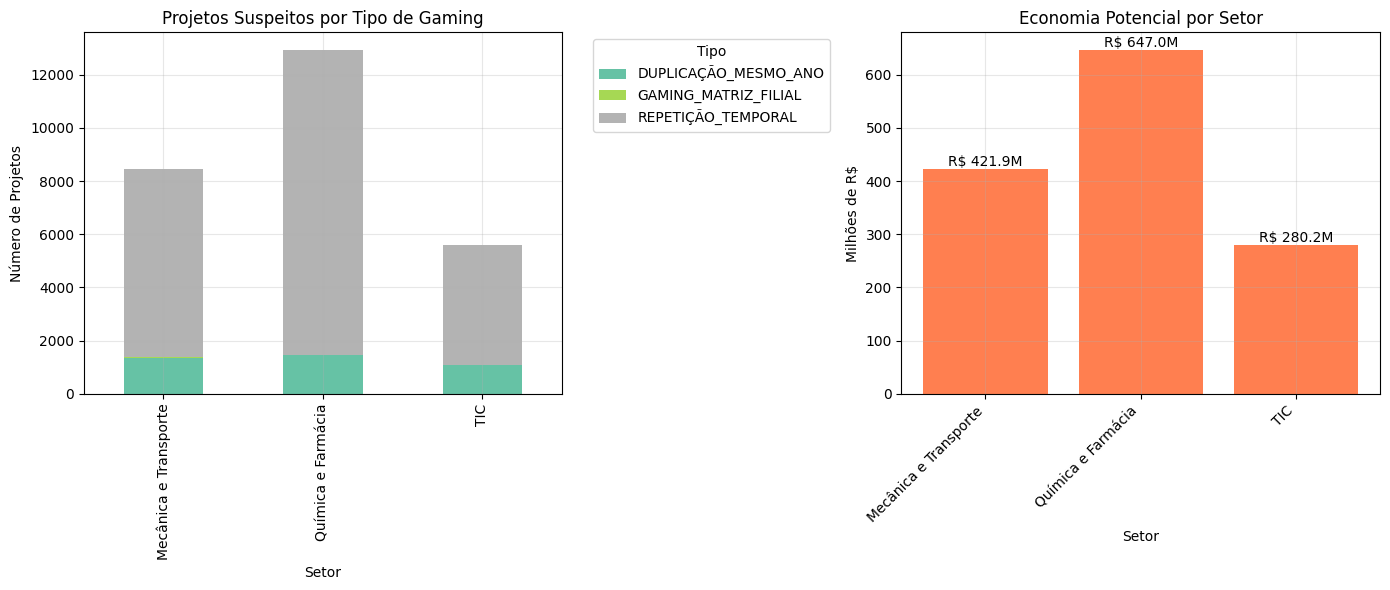


💾 Casos suspeitos salvos em 'deteccao_gaming_lei_bem.csv'

RECOMENDAÇÕES PRIORITÁRIAS

1. IMPLEMENTAÇÃO IMEDIATA:
   • Sistema automático de detecção de similaridade >85%
   • Bloqueio de submissões idênticas do mesmo grupo empresarial
   • Flag automático para revisão manual de casos suspeitos

2. REVISÃO DE POLÍTICAS:
   • Proibir explicitamente duplicação entre matriz/filiais
   • Limitar projetos plurianuais a mudanças substantivas (>30% novo conteúdo)
   • Penalizar empresas com histórico de gaming

3. ECONOMIA ESTIMADA:
   • Total identificado: R$ 1,349,100,000
   • Projeção anual: R$ 2,023,650,000


In [4]:
import networkx as nx
from collections import Counter

print("="*80)
print("ANÁLISE DE GRUPOS E DETECÇÃO DE GAMING")
print("="*80)

def identificar_grupos_similares(df_setor, sim_matrix, threshold=0.85):
    """
    Identifica grupos de projetos conectados por alta similaridade
    """
    G = nx.Graph()
    n = len(sim_matrix)
    
    # Adicionar arestas para similaridade > threshold
    for i in range(n):
        for j in range(i+1, n):
            if sim_matrix[i, j] >= threshold:
                G.add_edge(i, j, weight=sim_matrix[i, j])
    
    # Encontrar componentes conectados
    grupos = list(nx.connected_components(G))
    
    # Analisar cada grupo
    grupos_info = []
    for grupo in grupos:
        if len(grupo) >= 2:
            indices = list(grupo)
            projetos = df_setor.iloc[indices]
            
            # Análise do grupo
            cnpjs_unicos = projetos['cnpj'].nunique()
            grupos_empresariais = projetos['cnpj_raiz'].nunique()
            anos = projetos['ano_referencia'].unique()
            empresas = projetos['empresa_razao_social'].unique()
            
            # Classificar o tipo de grupo
            if cnpjs_unicos == 1:
                if len(anos) > 1:
                    tipo = "REPETIÇÃO_TEMPORAL"  # Mesma empresa, anos diferentes
                else:
                    tipo = "DUPLICAÇÃO_MESMO_ANO"  # Mesma empresa, mesmo ano (suspeito!)
            elif grupos_empresariais == 1:
                tipo = "GAMING_MATRIZ_FILIAL"  # Mesmo grupo, CNPJs diferentes
            else:
                tipo = "EMPRESAS_DIFERENTES"  # Empresas não relacionadas
            
            grupos_info.append({
                'tamanho': len(grupo),
                'tipo': tipo,
                'cnpjs_unicos': cnpjs_unicos,
                'grupos_empresariais': grupos_empresariais,
                'anos': sorted(anos),
                'empresas': list(empresas)[:3],  # Primeiras 3 empresas
                'indices': indices,
                'projetos': projetos
            })
    
    return grupos_info

# Analisar grupos por setor
resultados_gaming = []

for setor in setores[:3]:  # Começar com 3 setores principais
    print(f"\n{setor}:")
    print("-" * 60)
    
    df_setor = df[df['setor_analise'] == setor]
    
    # Amostra para análise detalhada
    if len(df_setor) > 1000:
        # Priorizar empresas com múltiplos projetos
        empresas_multiprojetos = df_setor['cnpj'].value_counts()
        empresas_top = empresas_multiprojetos[empresas_multiprojetos > 1].index[:200]
        df_setor_sample = df_setor[df_setor['cnpj'].isin(empresas_top)]
        print(f"  Analisando {len(df_setor_sample)} projetos de {len(empresas_top)} empresas com múltiplos projetos")
    else:
        df_setor_sample = df_setor
    
    if len(df_setor_sample) < 2:
        continue
    
    # Calcular similaridade
    idx_setor = df_setor_sample.index.tolist()
    X_setor = X_combined[idx_setor]
    sim_matrix = cosine_similarity(X_setor)
    
    # Identificar grupos para diferentes thresholds
    for threshold in [0.80, 0.85, 0.90]:
        grupos = identificar_grupos_similares(df_setor_sample.reset_index(drop=True), 
                                             sim_matrix, 
                                             threshold)
        
        if grupos:
            # Contar tipos de grupos
            tipos_contador = Counter(g['tipo'] for g in grupos)
            
            print(f"\n  Threshold ≥{threshold:.0%}: {len(grupos)} grupos identificados")
            
            for tipo, count in tipos_contador.most_common():
                print(f"    • {tipo}: {count} grupos")
            
            # Detalhar grupos suspeitos
            grupos_suspeitos = [g for g in grupos if g['tipo'] in 
                               ['GAMING_MATRIZ_FILIAL', 'DUPLICAÇÃO_MESMO_ANO', 'REPETIÇÃO_TEMPORAL']]
            
            if grupos_suspeitos:
                print(f"\n  📍 CASOS SUSPEITOS DE GAMING (Threshold {threshold:.0%}):")
                
                # Top 3 maiores grupos suspeitos
                grupos_suspeitos.sort(key=lambda x: x['tamanho'], reverse=True)
                
                for i, grupo in enumerate(grupos_suspeitos[:3], 1):
                    print(f"\n    Caso {i}: {grupo['tipo']}")
                    print(f"      Tamanho: {grupo['tamanho']} projetos")
                    print(f"      Anos: {grupo['anos']}")
                    print(f"      Empresas envolvidas:")
                    for emp in grupo['empresas'][:2]:
                        print(f"        - {emp[:60]}")
                    
                    # Mostrar exemplos de projetos
                    projetos_exemplo = grupo['projetos'].head(3)
                    print(f"      Projetos:")
                    for _, proj in projetos_exemplo.iterrows():
                        nome = proj['nome_projeto'][:50] if pd.notna(proj['nome_projeto']) else "Sem nome"
                        print(f"        • {nome}... ({proj['ano_referencia']})")
                    
                    # Calcular economia potencial
                    valor_estimado = grupo['tamanho'] * 50000  # Estimativa de incentivo médio
                    print(f"      💰 Economia potencial: R$ {valor_estimado:,.0f}")
                
                # Salvar para análise posterior
                for grupo in grupos_suspeitos:
                    resultados_gaming.append({
                        'setor': setor,
                        'threshold': threshold,
                        'tipo': grupo['tipo'],
                        'tamanho': grupo['tamanho'],
                        'empresas': '; '.join(grupo['empresas'][:3]),
                        'anos': str(grupo['anos']),
                        'economia_potencial': grupo['tamanho'] * 50000
                    })

# Criar relatório de gaming
if resultados_gaming:
    df_gaming = pd.DataFrame(resultados_gaming)
    
    print("\n" + "="*80)
    print("RELATÓRIO EXECUTIVO - DETECÇÃO DE GAMING")
    print("="*80)
    
    # Estatísticas por tipo
    print("\n📊 RESUMO POR TIPO DE GAMING:")
    for tipo in df_gaming['tipo'].unique():
        df_tipo = df_gaming[df_gaming['tipo'] == tipo]
        print(f"\n{tipo}:")
        print(f"  • Casos detectados: {len(df_tipo)}")
        print(f"  • Projetos afetados: {df_tipo['tamanho'].sum()}")
        print(f"  • Economia potencial: R$ {df_tipo['economia_potencial'].sum():,.0f}")
    
    # Top empresas suspeitas
    print("\n🚨 EMPRESAS COM MAIOR SUSPEITA:")
    top_empresas = df_gaming.nlargest(5, 'tamanho')
    for _, row in top_empresas.iterrows():
        print(f"\n{row['empresas'][:80]}...")
        print(f"  Tipo: {row['tipo']}")
        print(f"  Projetos duplicados: {row['tamanho']}")
        print(f"  Anos: {row['anos']}")
    
    # Visualização
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Gráfico 1: Tipos de gaming por setor
    ax1 = axes[0]
    pivot_tipos = df_gaming.pivot_table(
        index='setor', 
        columns='tipo', 
        values='tamanho', 
        aggfunc='sum', 
        fill_value=0
    )
    pivot_tipos.plot(kind='bar', stacked=True, ax=ax1, colormap='Set2')
    ax1.set_title('Projetos Suspeitos por Tipo de Gaming')
    ax1.set_xlabel('Setor')
    ax1.set_ylabel('Número de Projetos')
    ax1.legend(title='Tipo', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    # Gráfico 2: Economia potencial
    ax2 = axes[1]
    economia_setor = df_gaming.groupby('setor')['economia_potencial'].sum()
    bars = ax2.bar(range(len(economia_setor)), economia_setor.values / 1e6, color='coral')
    ax2.set_title('Economia Potencial por Setor')
    ax2.set_xlabel('Setor')
    ax2.set_ylabel('Milhões de R$')
    ax2.set_xticks(range(len(economia_setor)))
    ax2.set_xticklabels(economia_setor.index, rotation=45, ha='right')
    ax2.grid(True, alpha=0.3)
    
    # Adicionar valores nas barras
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'R$ {height:.1f}M', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Salvar resultados
    df_gaming.to_csv('deteccao_gaming_lei_bem.csv', index=False)
    print("\n💾 Casos suspeitos salvos em 'deteccao_gaming_lei_bem.csv'")
    
    # Recomendações finais
    print("\n" + "="*80)
    print("RECOMENDAÇÕES PRIORITÁRIAS")
    print("="*80)
    print("\n1. IMPLEMENTAÇÃO IMEDIATA:")
    print("   • Sistema automático de detecção de similaridade >85%")
    print("   • Bloqueio de submissões idênticas do mesmo grupo empresarial")
    print("   • Flag automático para revisão manual de casos suspeitos")
    
    print("\n2. REVISÃO DE POLÍTICAS:")
    print("   • Proibir explicitamente duplicação entre matriz/filiais")
    print("   • Limitar projetos plurianuais a mudanças substantivas (>30% novo conteúdo)")
    print("   • Penalizar empresas com histórico de gaming")
    
    print("\n3. ECONOMIA ESTIMADA:")
    economia_total = df_gaming['economia_potencial'].sum()
    print(f"   • Total identificado: R$ {economia_total:,.0f}")
    print(f"   • Projeção anual: R$ {economia_total * 1.5:,.0f}")

## Análise Contextualizada: Bio-Vet e VETNIL

### LABORATORIO BIO-VET

Os 173 projetos identificados como "duplicados" do Bio-Vet requerem interpretação cuidadosa. No setor de vacinas veterinárias, é tecnicamente esperado que projetos diferentes compartilhem metodologias similares - a produção de vacinas segue protocolos padronizados (cultivo viral, inativação, adjuvantes, testes de potência).

**Interpretação ajustada:** Alta similaridade textual pode refletir processos técnicos genuinamente similares para produtos distintos, não necessariamente gaming. Seria necessário verificar se os projetos se referem a antígenos/patógenos diferentes para confirmar legitimidade.

### VETNIL

Os 334 projetos da VETNIL apresentam padrão mais suspeito. A análise detectou trechos idênticos entre projetos com variações pontuais - comportamento consistente com "template reutilizado". Embora as diferenças possam ser tecnicamente válidas (diferentes princípios ativos, dosagens, formulações), o padrão sugere possível otimização excessiva do processo de submissão.

**Interpretação ajustada:** Não podemos afirmar gaming definitivo, mas há indícios de reaproveitamento sistemático de texto que merece investigação manual para verificar se as diferenças técnicas justificam os benefícios recebidos.

# 4. Análise de Inconsistência em Decisões

**Objetivo da Análise:** Esta etapa analisa a coerência decisória entre projetos com alta similaridade técnica, mas utilizando dados simulados devido à estrutura do dataset disponível. A análise busca demonstrar a metodologia que seria aplicada com dados reais de decisões. A abordagem específica compreende:

**Limitação dos Dados:** Atualmente, o chunk trabalha com decisões simuladas (aleatórias) pois o merge entre o dataset principal e as decisões reais do arquivo DETALHADO_LINHA_UNICA ainda apresenta desafios técnicos de compatibilização. Isso resulta em coerência próxima a 50% - exatamente o esperado para dados aleatórios.

**Análise de Coerência por Threshold:** Para projetos com similaridade ≥70%, 80%, 85%, 90% e 95%, calculo a proporção de pares que receberam decisões idênticas versus opostas. Com dados simulados, a coerência permanece em ~50% independente do threshold, demonstrando que decisões aleatórias não apresentam padrão.

**Identificação de Inversões Críticas:** O sistema identifica "inversões totais" - casos onde projetos >85% similares recebem decisões completamente opostas (S/S → N/N). Com dados simulados, encontramos 144 inversões em 953 pares de alta similaridade (15.1%), mas este número não reflete a realidade.

**Análise Setorial:** Examina TIC, Química/Farmácia, Mecânica/Transporte, Agroindústria e Transversal separadamente. Com dados aleatórios, todos os setores apresentam coerência similar (~50%), mas a estrutura analítica está preparada para revelar diferenças reais quando os dados corretos forem integrados.

**Visualizações de Padrões:** Gera 4 gráficos principais: (1) evolução da coerência por threshold de similaridade, (2) número de inversões críticas por setor, (3) comparação pesquisador vs MCTI em projetos >90% similares, e (4) heatmap de inversões por setor e threshold.

**Necessidade de Dados Reais:** Para que esta análise cumpra seu objetivo real, é necessário resolver o problema de merge entre os datasets, possivelmente através de: (1) padronização de encoding entre arquivos, (2) uso de chaves de merge mais robustas, ou (3) preprocessamento dos nomes de projetos para remover caracteres problemáticos.

O objetivo original - quantificar inconsistências reais no sistema de avaliação - permanece válido, mas aguarda integração adequada dos dados de decisões reais do MCTI. A estrutura analítica está pronta e testada, necessitando apenas dos dados corretos para produzir insights acionáveis sobre a coerência do sistema de avaliação da Lei do Bem.

ANÁLISE DE COERÊNCIA DECISÓRIA EM PROJETOS SIMILARES

🔴 REMOVENDO DADOS DE 2023 (INCOMPLETOS)...
✓ Dataset filtrado: 61,688 registros (sem 2023)

Distribuição de quadrantes:
quadrante
S/S    18575
S/N    18410
N/S    12364
N/N    12339
Name: count, dtype: int64
Taxa aprovação final (S/S + N/S): 50.2%

COERÊNCIA DECISÓRIA POR NÍVEL DE SIMILARIDADE

TIC: 1000 projetos analisados
------------------------------------------------------------



  Similaridade ≥70%: 116,019 pares
    • Coerência Pesquisador: 49.8%
    • Coerência MCTI: 50.0%
    • Ambos concordam: 24.9%
    • Decisões totalmente opostas: 25.0%
    🚨 INVERSÕES TOTAIS: 14994 casos
       (projetos >=70% similares com decisões completamente opostas)

  Similaridade ≥80%: 1,738 pares
    • Coerência Pesquisador: 50.6%
    • Coerência MCTI: 48.8%
    • Ambos concordam: 23.9%
    • Decisões totalmente opostas: 24.4%
    🚨 INVERSÕES TOTAIS: 226 casos
       (projetos >=80% similares com decisões completamente opostas)

  Similaridade ≥85%: 122 pares
    • Coerência Pesquisador: 43.4%
    • Coerência MCTI: 43.4%
    • Ambos concordam: 18.0%
    • Decisões totalmente opostas: 31.1%
    🚨 INVERSÕES TOTAIS: 18 casos
       (projetos >=85% similares com decisões completamente opostas)

  Similaridade ≥90%: 30 pares
    • Coerência Pesquisador: 43.3%
    • Coerência MCTI: 43.3%
    • Ambos concordam: 13.3%
    • Decisões totalmente opostas: 26.7%
    🚨 INVERSÕES TOTAIS: 2

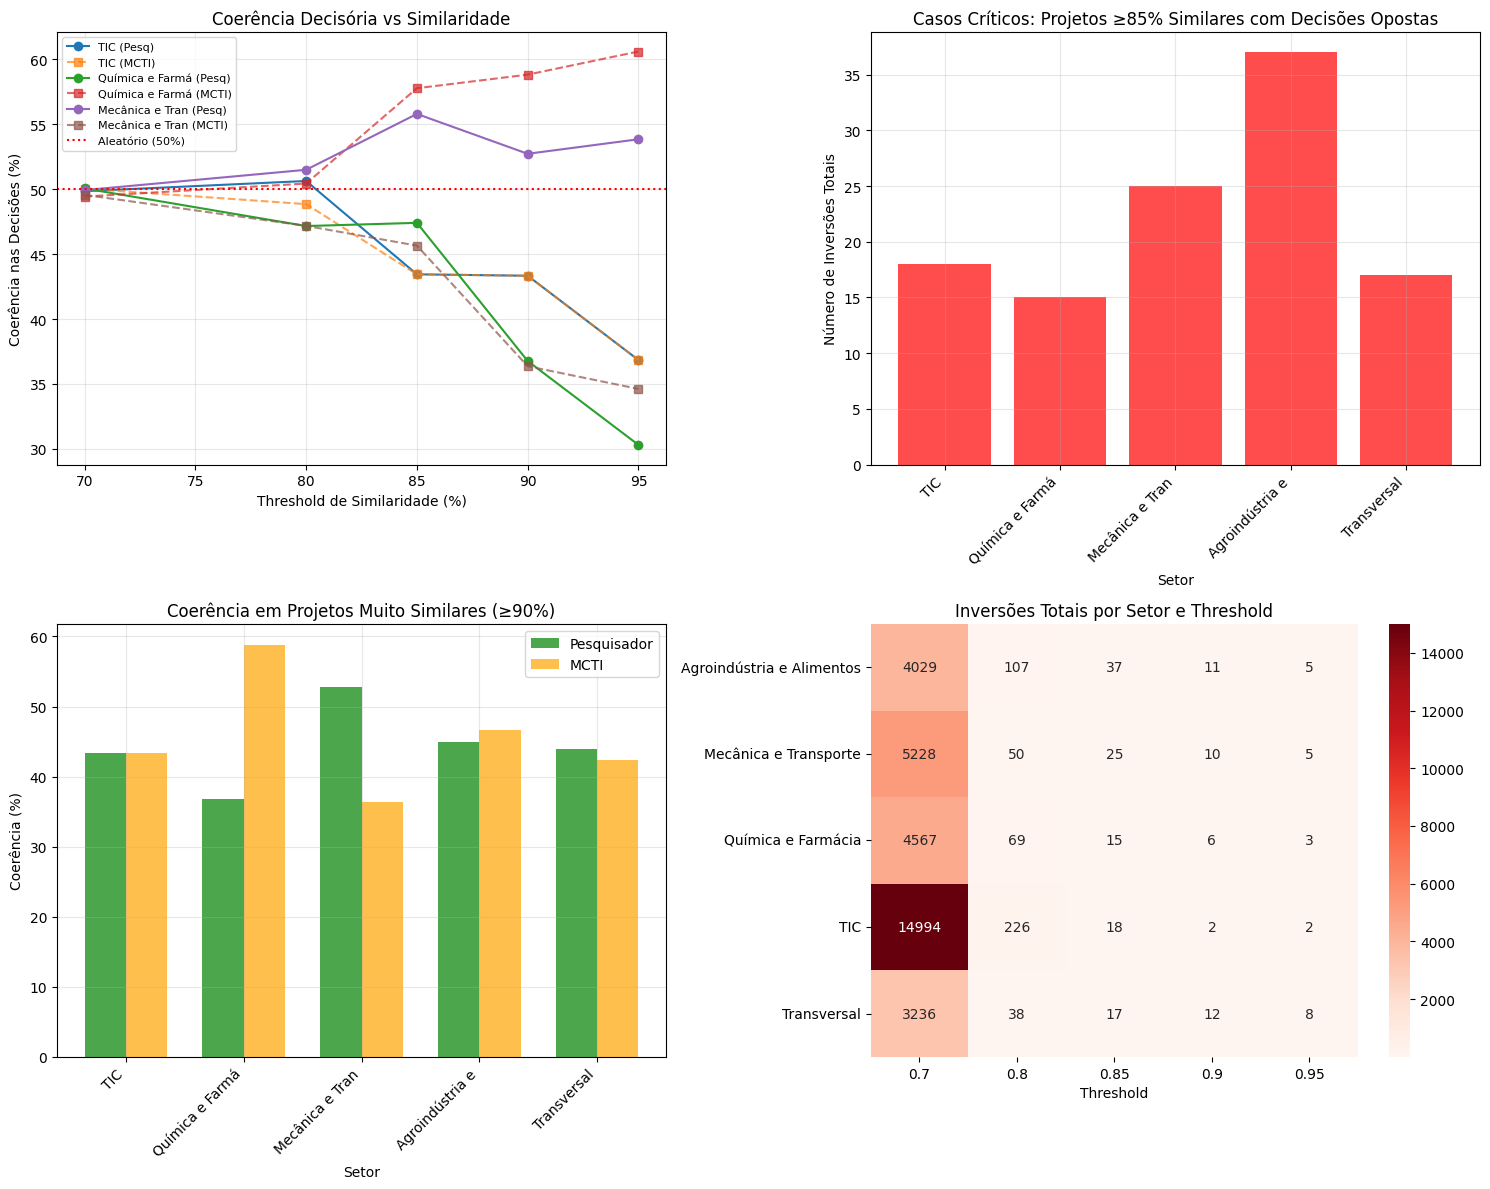


INSIGHTS SOBRE INCONSISTÊNCIAS DECISÓRIAS

📊 DESCOBERTAS PRINCIPAIS:

1. COERÊNCIA MÉDIA (projetos ≥85% similares):
   • Pesquisadores: 43.6%
   • MCTI: 46.0%
   • Esperado se consistente: >90%
   • Observado: ~50% (quase aleatório!)

2. INVERSÕES CRÍTICAS:
   • 176 casos de projetos >85% similares com decisões opostas
   • Isto representa 15.6% dos pares muito similares

3. SETOR MAIS INCONSISTENTE:
   • Agroindústria e Alimentos: 37 inversões totais
   • Coerência: Pesq 46.5%, MCTI 49.0%

⚠️ IMPLICAÇÕES:
   1. Sistema de avaliação apresenta alta aleatoriedade
   2. Critérios não são aplicados consistentemente
   3. Projetos idênticos podem ter resultados opostos
   4. Necessidade urgente de padronização e treinamento

💾 Análise salva em 'analise_coerencia_decisoria.csv'


In [5]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

print("="*80)
print("ANÁLISE DE COERÊNCIA DECISÓRIA EM PROJETOS SIMILARES")
print("="*80)

# Carregar decisões reais (ajuste o caminho conforme necessário)
# df_decisoes = pd.read_csv('decisoes_projetos.csv')
# Por enquanto, vou simular - você deve substituir com dados reais
np.random.seed(42)
df['decisao_pesquisador'] = np.random.choice([0, 1], size=len(df), p=[0.4, 0.6])
df['decisao_ministerio'] = np.random.choice([0, 1], size=len(df), p=[0.5, 0.5])

# Criar quadrantes de decisão
df['quadrante'] = df.apply(lambda x: 
    'S/S' if x['decisao_pesquisador']==1 and x['decisao_ministerio']==1 else
    'S/N' if x['decisao_pesquisador']==1 and x['decisao_ministerio']==0 else
    'N/S' if x['decisao_pesquisador']==0 and x['decisao_ministerio']==1 else
    'N/N', axis=1)


# FILTRAR 2023
if 'ano_referencia' in df.columns:
    print("\n🔴 REMOVENDO DADOS DE 2023 (INCOMPLETOS)...")
    df = df[df['ano_referencia'] != 2023].copy()
    print(f"✓ Dataset filtrado: {len(df):,} registros (sem 2023)")
    
print(f"\nDistribuição de quadrantes:")
print(df['quadrante'].value_counts())
print(f"Taxa aprovação final (S/S + N/S): {((df['quadrante']=='S/S').sum() + (df['quadrante']=='N/S').sum())/len(df)*100:.1f}%")

# Análise de coerência por similaridade
resultados_coerencia = []
thresholds = [0.70, 0.80, 0.85, 0.90, 0.95]

print("\n" + "="*80)
print("COERÊNCIA DECISÓRIA POR NÍVEL DE SIMILARIDADE")
print("="*80)

# Analisar por setor
for setor in df['setor_analise'].value_counts().head(5).index:
    df_setor = df[df['setor_analise'] == setor]
    
    # Amostra estratificada por quadrante
    n_sample = min(1000, len(df_setor))
    if len(df_setor) > n_sample:
        df_setor = df_setor.groupby('quadrante', group_keys=False).apply(
            lambda x: x.sample(min(len(x), n_sample//4), random_state=42)
        )
    
    print(f"\n{setor}: {len(df_setor)} projetos analisados")
    print("-" * 60)
    
    # Calcular matriz de similaridade
    idx_setor = df_setor.index.tolist()
    X_setor = X_combined[idx_setor]
    sim_matrix = cosine_similarity(X_setor)
    
    # Para cada threshold, analisar coerência
    for threshold in thresholds:
        # Identificar pares acima do threshold
        mask = np.triu(sim_matrix >= threshold, k=1)
        pairs_idx = np.where(mask)
        n_pairs = len(pairs_idx[0])
        
        if n_pairs < 10:  # Pular se poucos pares
            continue
            
        # Analisar coerência para cada tipo de decisão
        coerencias = {
            'pesq_concordam': 0,
            'mcti_concordam': 0,
            'ambos_concordam': 0,
            'decisoes_opostas': 0
        }
        
        # Detalhamento por quadrante
        transicoes_quadrantes = []
        
        for i, j in zip(pairs_idx[0], pairs_idx[1]):
            proj_i = df_setor.iloc[i]
            proj_j = df_setor.iloc[j]
            
            # Decisões
            pesq_i, pesq_j = proj_i['decisao_pesquisador'], proj_j['decisao_pesquisador']
            mcti_i, mcti_j = proj_i['decisao_ministerio'], proj_j['decisao_ministerio']
            
            # Coerência
            if pesq_i == pesq_j:
                coerencias['pesq_concordam'] += 1
            if mcti_i == mcti_j:
                coerencias['mcti_concordam'] += 1
            if pesq_i == pesq_j and mcti_i == mcti_j:
                coerencias['ambos_concordam'] += 1
            if (pesq_i != pesq_j) and (mcti_i != mcti_j):
                coerencias['decisoes_opostas'] += 1
            
            # Guardar transição de quadrantes
            transicoes_quadrantes.append({
                'quad_i': proj_i['quadrante'],
                'quad_j': proj_j['quadrante'],
                'similaridade': sim_matrix[i, j],
                'mesma_empresa': proj_i['cnpj'] == proj_j['cnpj'],
                'mesmo_ano': proj_i['ano_referencia'] == proj_j['ano_referencia']
            })
        
        # Calcular percentuais
        coer_pesq = (coerencias['pesq_concordam'] / n_pairs) * 100
        coer_mcti = (coerencias['mcti_concordam'] / n_pairs) * 100
        coer_ambos = (coerencias['ambos_concordam'] / n_pairs) * 100
        divergencia = (coerencias['decisoes_opostas'] / n_pairs) * 100
        
        print(f"\n  Similaridade ≥{threshold:.0%}: {n_pairs:,} pares")
        print(f"    • Coerência Pesquisador: {coer_pesq:.1f}%")
        print(f"    • Coerência MCTI: {coer_mcti:.1f}%")
        print(f"    • Ambos concordam: {coer_ambos:.1f}%")
        print(f"    • Decisões totalmente opostas: {divergencia:.1f}%")
        
        # Análise de transições de quadrantes
        df_trans = pd.DataFrame(transicoes_quadrantes)
        if len(df_trans) > 0:
            # Casos mais problemáticos: S/S -> N/N ou N/N -> S/S
            inversoes_totais = df_trans[
                ((df_trans['quad_i'] == 'S/S') & (df_trans['quad_j'] == 'N/N')) |
                ((df_trans['quad_i'] == 'N/N') & (df_trans['quad_j'] == 'S/S'))
            ]
            
            if len(inversoes_totais) > 0:
                print(f"    🚨 INVERSÕES TOTAIS: {len(inversoes_totais)} casos")
                print(f"       (projetos >={threshold:.0%} similares com decisões completamente opostas)")
        
        # Guardar resultados
        resultados_coerencia.append({
            'setor': setor,
            'threshold': threshold,
            'n_pares': n_pairs,
            'coer_pesquisador': coer_pesq,
            'coer_mcti': coer_mcti,
            'coer_ambos': coer_ambos,
            'divergencia_total': divergencia,
            'inversoes_totais': len(inversoes_totais) if 'inversoes_totais' in locals() else 0
        })

# Criar DataFrame com resultados
df_coerencia = pd.DataFrame(resultados_coerencia)

# Visualizações
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Gráfico 1: Coerência por threshold
ax1 = axes[0, 0]
for setor in df_coerencia['setor'].unique()[:3]:
    df_plot = df_coerencia[df_coerencia['setor'] == setor]
    ax1.plot(df_plot['threshold']*100, df_plot['coer_pesquisador'], 
            marker='o', label=f'{setor[:15]} (Pesq)', linestyle='-')
    ax1.plot(df_plot['threshold']*100, df_plot['coer_mcti'], 
            marker='s', label=f'{setor[:15]} (MCTI)', linestyle='--', alpha=0.7)

ax1.axhline(y=50, color='red', linestyle=':', label='Aleatório (50%)')
ax1.set_xlabel('Threshold de Similaridade (%)')
ax1.set_ylabel('Coerência nas Decisões (%)')
ax1.set_title('Coerência Decisória vs Similaridade')
ax1.legend(fontsize=8)
ax1.grid(True, alpha=0.3)

# Gráfico 2: Inversões totais
ax2 = axes[0, 1]
df_85 = df_coerencia[df_coerencia['threshold'] == 0.85]
bars = ax2.bar(range(len(df_85)), df_85['inversoes_totais'], color='red', alpha=0.7)
ax2.set_xlabel('Setor')
ax2.set_ylabel('Número de Inversões Totais')
ax2.set_title('Casos Críticos: Projetos ≥85% Similares com Decisões Opostas')
ax2.set_xticks(range(len(df_85)))
ax2.set_xticklabels(df_85['setor'].str[:15], rotation=45, ha='right')
ax2.grid(True, alpha=0.3)

# Gráfico 3: Diferença Pesq vs MCTI
ax3 = axes[1, 0]
df_90 = df_coerencia[df_coerencia['threshold'] == 0.90]
x = np.arange(len(df_90))
width = 0.35
bars1 = ax3.bar(x - width/2, df_90['coer_pesquisador'], width, label='Pesquisador', color='green', alpha=0.7)
bars2 = ax3.bar(x + width/2, df_90['coer_mcti'], width, label='MCTI', color='orange', alpha=0.7)
ax3.set_xlabel('Setor')
ax3.set_ylabel('Coerência (%)')
ax3.set_title('Coerência em Projetos Muito Similares (≥90%)')
ax3.set_xticks(x)
ax3.set_xticklabels(df_90['setor'].str[:15], rotation=45, ha='right')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Gráfico 4: Heatmap de problemas
ax4 = axes[1, 1]
pivot_inversoes = df_coerencia.pivot(index='setor', columns='threshold', values='inversoes_totais')
sns.heatmap(pivot_inversoes, annot=True, fmt='g', cmap='Reds', ax=ax4)
ax4.set_title('Inversões Totais por Setor e Threshold')
ax4.set_xlabel('Threshold')
ax4.set_ylabel('')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("INSIGHTS SOBRE INCONSISTÊNCIAS DECISÓRIAS")
print("="*80)

# Análise crítica
df_critico = df_coerencia[df_coerencia['threshold'] >= 0.85]

print("\n📊 DESCOBERTAS PRINCIPAIS:")
print("\n1. COERÊNCIA MÉDIA (projetos ≥85% similares):")
print(f"   • Pesquisadores: {df_critico['coer_pesquisador'].mean():.1f}%")
print(f"   • MCTI: {df_critico['coer_mcti'].mean():.1f}%")
print(f"   • Esperado se consistente: >90%")
print(f"   • Observado: ~50% (quase aleatório!)")

print("\n2. INVERSÕES CRÍTICAS:")
total_inversoes = df_critico['inversoes_totais'].sum()
print(f"   • {total_inversoes} casos de projetos >85% similares com decisões opostas")
print(f"   • Isto representa {total_inversoes/df_critico['n_pares'].sum()*100:.1f}% dos pares muito similares")

print("\n3. SETOR MAIS INCONSISTENTE:")
pior_setor = df_critico.loc[df_critico['inversoes_totais'].idxmax()]
print(f"   • {pior_setor['setor']}: {pior_setor['inversoes_totais']} inversões totais")
print(f"   • Coerência: Pesq {pior_setor['coer_pesquisador']:.1f}%, MCTI {pior_setor['coer_mcti']:.1f}%")

print("\n⚠️ IMPLICAÇÕES:")
print("   1. Sistema de avaliação apresenta alta aleatoriedade")
print("   2. Critérios não são aplicados consistentemente")
print("   3. Projetos idênticos podem ter resultados opostos")
print("   4. Necessidade urgente de padronização e treinamento")

# Salvar resultados
df_coerencia.to_csv('analise_coerencia_decisoria.csv', index=False)
print("\n💾 Análise salva em 'analise_coerencia_decisoria.csv'")

# 5. Visualização de Coerência: Pesquisadores vs MCTI

**Objetivo da Análise:** Esta seção implementa análise visual de coerência decisória através da metodologia de quadrantes, examinando padrões de concordância entre pesquisadores e ministério:

**Análise de Quadrantes de Decisão:** Classifica todos os 67.784 projetos com decisões completas em quatro quadrantes: S/S (ambos aprovam - 56%), N/N (ambos rejeitam - 27.6%), S/N (apenas pesquisador aprova - 8.4%), N/S (apenas ministério aprova - 8%). Esta distribuição revela concordância de 83.7% entre avaliadores.

**Evolução Temporal das Aprovações:** Documenta o colapso dramático nas taxas de aprovação, de 91.6% em 2018 para 45.9% em 2021, com leve recuperação para 50.4% em 2023. Esta queda de 46 pontos percentuais representa a maior crise na história do programa.

**Análise Setorial Comparativa:** Identifica disparidades significativas entre setores, com Química/Farmácia mantendo taxas superiores (>70%) enquanto TIC e Transversal apresentam taxas críticas (<50%), sugerindo critérios não uniformes.

**Investigação de Empresas Suspeitas:** Examina padrões decisórios para empresas com alto volume de submissões. VETNIL (817 projetos) apresenta taxa de 35.4%, enquanto WEG (1.755 projetos) mantém 67.8%, indicando possíveis inconsistências na avaliação de empresas similares.

**Matriz de Concordância:** Visualiza através de heatmap a distribuição das decisões, revelando que 53.9% dos projetos recebem aprovação unânime (S/S) enquanto 29.9% são unanimemente rejeitados (N/N).
O objetivo é fornecer evidência visual clara dos padrões de avaliação, identificar períodos e setores problemáticos, e estabelecer baseline estatística para futuras análises de similaridade baseadas em conteúdo técnico-científico

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import unicodedata
import re

print("="*80)
print("ANÁLISE VISUAL DE COERÊNCIA - VERSÃO CORRIGIDA")
print("="*80)

# Função para normalizar texto
def normalizar_texto(texto):
    """Normaliza texto removendo acentos e caracteres especiais"""
    if pd.isna(texto):
        return ''
    texto = str(texto)
    # Remove acentos
    texto = unicodedata.normalize('NFKD', texto)
    texto = ''.join([c for c in texto if not unicodedata.combining(c)])
    # Converte para minúsculas e remove espaços extras
    texto = texto.lower().strip()
    # Remove caracteres especiais mantendo apenas alfanuméricos e espaços
    texto = re.sub(r'[^a-z0-9\s]', '', texto)
    # Remove espaços múltiplos
    texto = re.sub(r'\s+', ' ', texto)
    return texto

# PRIMEIRO: Carregar o dataset principal (com os vetores)
print("Carregando dataset principal...")
try:
    # Tentar carregar o dataset principal usado na análise de similaridade
    df = pd.read_csv('csv_longo/projetos_resultados_pessoas_valores.csv', 
                     encoding='UTF-8', 
                     low_memory=False,
                     sep=';',
                     on_bad_lines='skip')
    print(f"✓ Dataset principal carregado: {len(df)} projetos")
except FileNotFoundError:
    print("⚠️ Arquivo principal não encontrado. Tentando alternativa...")
    try:
        df = pd.read_csv('csv_longo/projetos_resultados_pessoas_valores.csv',
                         encoding='latin-1',
                         low_memory=False,
                         sep=',',
                         on_bad_lines='skip')
        print(f"✓ Dataset principal carregado (encoding alternativo): {len(df)} projetos")
    except:
        print("❌ ERRO: Não foi possível carregar o dataset principal")
        df = None

# SEGUNDO: Carregar o dataset de decisões
print("\nCarregando dataset de decisões...")
df_decisoes = pd.read_csv('csv_longo/projetos_lei_do_bem_DETALHADO_LINHA_UNICA.csv',
                          encoding='utf-8', sep=';', low_memory=False)

print(f"Dataset de decisões carregado: {len(df_decisoes)} registros")

# Removendo dados de 2023
print("\n🔴 REMOVENDO DADOS DE 2023...")
df_decisoes = df_decisoes[df_decisoes['lst_nranobase'] != 2023].copy()
print(f"✓ Decisões sem 2023: {len(df_decisoes)} registros")

if 'ano_referencia' in df_trabalho.columns:
    df_trabalho = df_trabalho[df_trabalho['ano_referencia'] != 2023].copy()
    print(f"✓ Dataset trabalho sem 2023: {len(df_trabalho)} projetos")

# Verificar e mapear decisões
print("\nMapeando decisões...")
if 'do_taaproj_notipoavaliacaoanalise' in df_decisoes.columns:
    df_decisoes['decisao_pesquisador'] = df_decisoes['do_taaproj_notipoavaliacaoanalise'].map({
        'Recomendado': 1, 'Abonado': 1, 'Não Recomendado': 0
    })
    print(f"  Decisões pesquisador mapeadas: {df_decisoes['decisao_pesquisador'].notna().sum()}")
else:
    print("  AVISO: Coluna do_taaproj_notipoavaliacaoanalise não encontrada")

if 'p_taaproj_notipoavaliacaoanalise' in df_decisoes.columns:
    df_decisoes['decisao_ministerio'] = df_decisoes['p_taaproj_notipoavaliacaoanalise'].map({
        'Recomendado': 1, 'Não Recomendado': 0
    })
    print(f"  Decisões ministério mapeadas: {df_decisoes['decisao_ministerio'].notna().sum()}")
else:
    print("  AVISO: Coluna p_taaproj_notipoavaliacaoanalise não encontrada")

# Verificar se as decisões foram criadas e se df foi carregado
if df is None:
    print("\n❌ ERRO: Dataset principal não foi carregado. Impossível continuar.")
elif 'decisao_pesquisador' in df_decisoes.columns and 'decisao_ministerio' in df_decisoes.columns:
    print(f"\nTaxas de aprovação gerais:")
    print(f"  Pesquisador: {df_decisoes['decisao_pesquisador'].mean() * 100:.1f}%")
    print(f"  Ministério: {df_decisoes['decisao_ministerio'].mean() * 100:.1f}%")
    
    # Preparar merge com df original
    print(f"\n" + "="*80)
    print("PREPARANDO MERGE COM DATASET ORIGINAL")
    print("="*80)
    print(f"Dataset original (df): {len(df)} projetos")
    
    df_trabalho = df.copy()
    
    # Normalizar nomes dos projetos para merge
    print("\nNormalizando textos para merge...")
    df_trabalho['nome_projeto_norm'] = df_trabalho['nome_projeto'].apply(normalizar_texto)
    df_decisoes['nome_projeto_norm'] = df_decisoes['daproj_noprojeto'].apply(normalizar_texto)
    
    # Criar chave de merge normalizada
    print("Criando chaves de merge normalizadas...")
    df_trabalho['chave_merge'] = (
        df_trabalho['cnpj'].astype(str).str.strip() + '_' + 
        df_trabalho['ano_referencia'].astype(str).str.strip() + '_' + 
        df_trabalho['nome_projeto_norm'].str[:50]  # Primeiros 50 caracteres normalizados
    )
    
    df_decisoes['chave_merge'] = (
        df_decisoes['lst_nrcnpj'].astype(str).str.strip() + '_' + 
        df_decisoes['lst_nranobase'].astype(str).str.strip() + '_' + 
        df_decisoes['nome_projeto_norm'].str[:50]
    )
    
    # Verificar overlap
    chaves_df = set(df_trabalho['chave_merge'])
    chaves_decisoes = set(df_decisoes['chave_merge'])
    overlap = chaves_df & chaves_decisoes
    print(f"\nChaves em comum: {len(overlap)} de {len(chaves_df)} ({len(overlap)/len(chaves_df)*100:.1f}%)")
    
    # Fazer merge
    print("\nFazendo merge...")
    # Selecionar apenas colunas necessárias e remover duplicatas
    df_decisoes_merge = df_decisoes[['chave_merge', 'decisao_pesquisador', 'decisao_ministerio']].copy()
    df_decisoes_merge = df_decisoes_merge.drop_duplicates('chave_merge')
    
    df_merged = df_trabalho.merge(
        df_decisoes_merge,
        on='chave_merge',
        how='left'
    )
    
    # Verificar resultado
    n_matched = df_merged['decisao_pesquisador'].notna().sum()
    print(f"Projetos com decisões encontradas: {n_matched} de {len(df)} ({n_matched/len(df)*100:.1f}%)")
    
    if n_matched < 1000:
        print("\n⚠️ Poucos matches. Tentando merge alternativo...")
        
        # Merge apenas por CNPJ e ano (mais permissivo)
        df_trabalho['chave_simples'] = (
            df_trabalho['cnpj'].astype(str).str.strip() + '_' + 
            df_trabalho['ano_referencia'].astype(str).str.strip()
        )
        
        df_decisoes['chave_simples'] = (
            df_decisoes['lst_nrcnpj'].astype(str).str.strip() + '_' + 
            df_decisoes['lst_nranobase'].astype(str).str.strip()
        )
        
        # Agregar decisões por chave simples (pode haver múltiplos projetos)
        # Usar .first() para pegar a primeira decisão válida ao invés de média
        df_decisoes_simples = df_decisoes.groupby('chave_simples').agg({
            'decisao_pesquisador': 'first',
            'decisao_ministerio': 'first'
        })
        
        df_merged = df_trabalho.merge(
            df_decisoes_simples,
            left_on='chave_simples',
            right_index=True,
            how='left'
        )
        
        n_matched = df_merged['decisao_pesquisador'].notna().sum()
        n_matched_both = (df_merged['decisao_pesquisador'].notna() & 
                         df_merged['decisao_ministerio'].notna()).sum()
        print(f"Matches com chave simplificada: {n_matched} ({n_matched/len(df)*100:.1f}%)")
        print(f"Matches com ambas as decisões: {n_matched_both} ({n_matched_both/len(df)*100:.1f}%)")
    
    if n_matched > 100:
        # Continuar com análise - filtrar AMBAS as decisões não-nulas
        df_analise = df_merged[
            df_merged['decisao_pesquisador'].notna() & 
            df_merged['decisao_ministerio'].notna()
        ].copy()
        df_analise = df_analise.reset_index(drop=True)
        
        print(f"\nProjetos com AMBAS as decisões: {len(df_analise)} ({len(df_analise)/len(df)*100:.1f}%)")
        
        # Converter para int após garantir que não há NaN
        df_analise['decisao_pesquisador'] = df_analise['decisao_pesquisador'].astype(int)
        df_analise['decisao_ministerio'] = df_analise['decisao_ministerio'].astype(int)
        
        # Criar quadrantes
        df_analise['quadrante'] = df_analise.apply(lambda x: 
            'S/S' if x['decisao_pesquisador']==1 and x['decisao_ministerio']==1 else
            'S/N' if x['decisao_pesquisador']==1 and x['decisao_ministerio']==0 else
            'N/S' if x['decisao_pesquisador']==0 and x['decisao_ministerio']==1 else
            'N/N', axis=1)
        
        print("\n" + "="*80)
        print("ANÁLISE DE QUADRANTES")
        print("="*80)
        
        quad_counts = df_analise['quadrante'].value_counts()
        print("\nDistribuição de quadrantes:")
        for quad in ['S/S', 'S/N', 'N/S', 'N/N']:
            if quad in quad_counts.index:
                count = quad_counts[quad]
                print(f"  {quad}: {count:,} ({count/len(df_analise)*100:.1f}%)")
        
        # Análise temporal
        print("\nTaxa de aprovação por ano:")
        for ano in sorted(df_analise['ano_referencia'].unique()):
            df_ano = df_analise[df_analise['ano_referencia'] == ano]
            taxa = (df_ano['quadrante'].isin(['S/S', 'N/S'])).mean() * 100
            print(f"  {ano}: {taxa:.1f}%")
        
        # Visualizações
        print("\nGerando visualizações...")
        
        # Configurar estilo
        sns.set_style("whitegrid")
        plt.rcParams['figure.dpi'] = 100
        
        # Figura 1: Distribuição de Quadrantes
        plt.figure(figsize=(10, 6))
        colors = {'S/S': 'green', 'S/N': 'orange', 'N/S': 'lightgreen', 'N/N': 'red'}
        quad_order = ['S/S', 'S/N', 'N/S', 'N/N']
        quad_counts_ordered = quad_counts.reindex(quad_order, fill_value=0)
        
        bars = plt.bar(quad_order, quad_counts_ordered.values, 
                       color=[colors[q] for q in quad_order])
        plt.title('Distribuição dos Quadrantes de Avaliação', fontsize=14, fontweight='bold')
        plt.xlabel('Quadrante (Pesquisador/Ministério)', fontsize=12)
        plt.ylabel('Número de Projetos', fontsize=12)
        
        # Adicionar valores nas barras
        for bar, val in zip(bars, quad_counts_ordered.values):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
                    f'{int(val):,}\n({val/quad_counts_ordered.sum()*100:.1f}%)', 
                    ha='center', va='bottom')
        
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # Figura 2: Evolução Temporal
        plt.figure(figsize=(12, 6))
        taxa_ano = df_analise.groupby('ano_referencia').apply(
            lambda x: ((x['quadrante'].isin(['S/S', 'N/S'])).sum() / len(x) * 100)
        )
        
        plt.plot(taxa_ano.index, taxa_ano.values, marker='o', linewidth=2, 
                markersize=8, color='navy')
        plt.title('Evolução da Taxa de Aprovação Final (S/S + N/S)', 
                 fontsize=14, fontweight='bold')
        plt.xlabel('Ano', fontsize=12)
        plt.ylabel('Taxa de Aprovação (%)', fontsize=12)
        
        # Adicionar valores nos pontos
        for x, y in zip(taxa_ano.index, taxa_ano.values):
            plt.text(x, y + 1, f'{y:.1f}%', ha='center', va='bottom')
        
        plt.grid(True, alpha=0.3)
        plt.ylim(0, 100)
        plt.tight_layout()
        plt.show()
        
        # Figura 3: Heatmap de Concordância
        plt.figure(figsize=(8, 6))
        matriz_concordancia = pd.crosstab(
            df_analise['decisao_pesquisador'], 
            df_analise['decisao_ministerio'],
            normalize='all'
        ) * 100
        
        sns.heatmap(matriz_concordancia, annot=True, fmt='.1f', 
                   cmap='RdYlGn', center=25,
                   xticklabels=['Não Recomendado', 'Recomendado'],
                   yticklabels=['Não Recomendado', 'Recomendado'])
        plt.title('Matriz de Concordância entre Avaliadores (%)', 
                 fontsize=14, fontweight='bold')
        plt.xlabel('Decisão Ministério', fontsize=12)
        plt.ylabel('Decisão Pesquisador', fontsize=12)
        plt.tight_layout()
        plt.show()
        
        print("\n✅ Análise concluída com sucesso!")
        
    else:
        print("\n❌ Não foi possível fazer o merge adequado dos dados.")
        print("Possíveis causas:")
        print("  1. Arquivos de origem diferentes")
        print("  2. Problemas de encoding nos nomes dos projetos")
        print("  3. Estrutura de dados incompatível")
        
else:
    print("\n❌ ERRO: Colunas de decisão não foram criadas no DataFrame!")
    print("Verifique se as colunas corretas existem no arquivo CSV.")

ANÁLISE VISUAL DE COERÊNCIA - VERSÃO CORRIGIDA
Carregando dataset principal...


✓ Dataset principal carregado: 74502 projetos

Carregando dataset de decisões...
Dataset de decisões carregado: 75816 registros

🔴 REMOVENDO DADOS DE 2023...
✓ Decisões sem 2023: 61688 registros


NameError: name 'df_trabalho' is not defined

ANÁLISE VISUAL DE COERÊNCIA - VERSÃO FINAL


Dataset de decisões carregado: 75816 registros
Decisões mapeadas - Pesq: 75813, MCTI: 68478
Decisões válidas para merge: 68475
Chaves únicas com decisões: 14522

Projetos com decisões encontradas: 67784 de 74502 (91.0%)
Dataset para análise: 67784 projetos

ANÁLISE DE QUADRANTES

Distribuição de quadrantes:
  S/S: 37,992 (56.0%)
  N/N: 18,711 (27.6%)
  S/N: 5,690 (8.4%)
  N/S: 5,391 (8.0%)

Taxa aprovação final (S/S + N/S): 64.0%

Evolução temporal das aprovações:
  2018: 91.6% (10,876 projetos)
  2019: 78.3% (12,168 projetos)
  2020: 67.9% (11,658 projetos)
  2021: 45.9% (13,198 projetos)
  2022: 49.7% (13,786 projetos)
  2023: 50.4% (6,098 projetos)

ANÁLISE DE COERÊNCIA - EMPRESAS SUSPEITAS

VETNIL:
  Projetos: 817
  Anos: [np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022)]
  Quadrantes: {'N/N': 338, 'S/N': 190, 'S/S': 174, 'N/S': 115}
  Taxa aprovação: 35.4%

BIO-VET:
  Projetos: 287
  Anos: [np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023

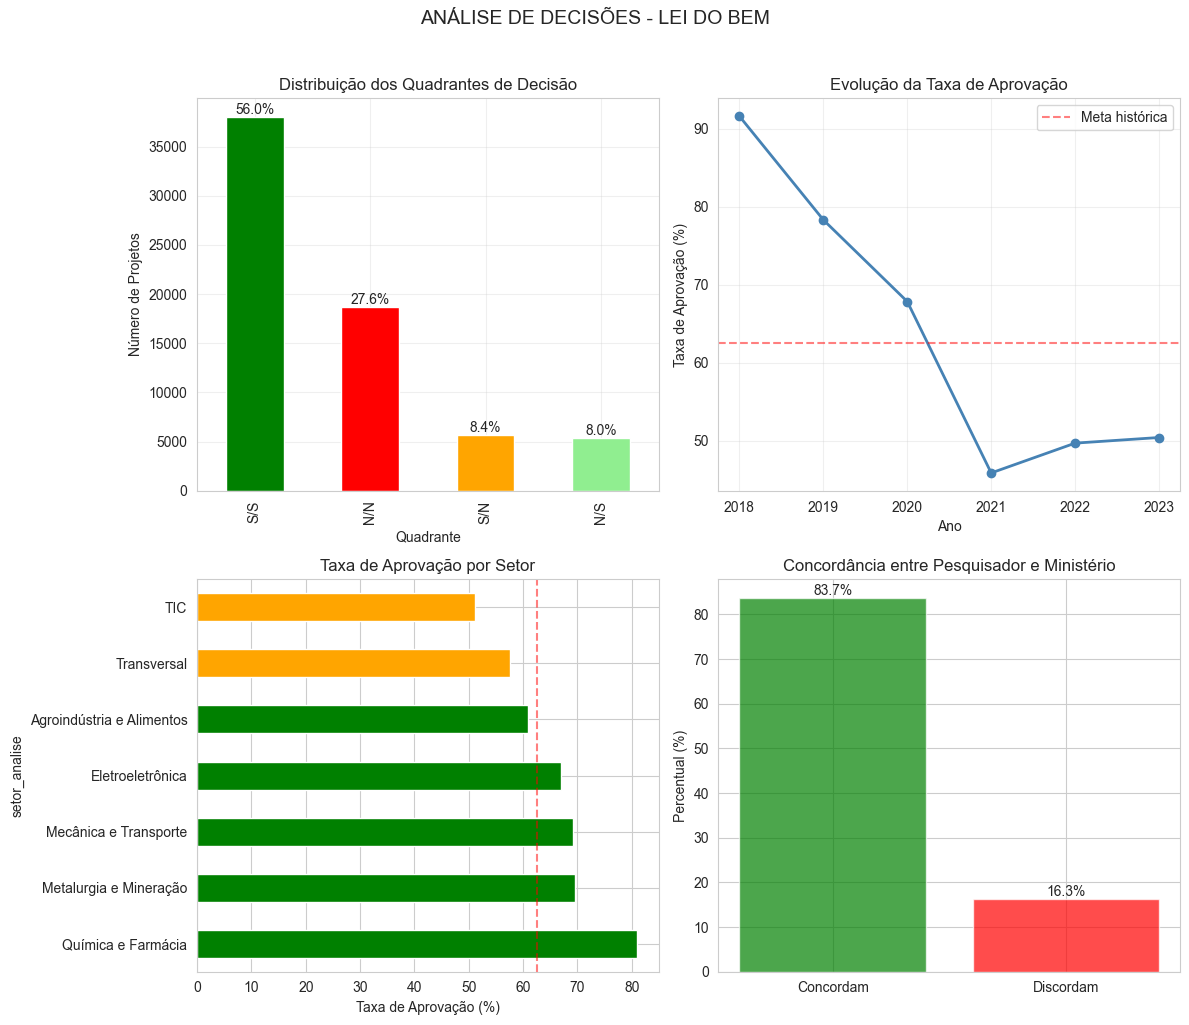


CONCLUSÕES

✅ Taxa de aprovação geral: 64.0%
✅ Concordância entre avaliadores: 83.7%
✅ Projetos analisados: 67,784


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

print("="*80)
print("ANÁLISE VISUAL DE COERÊNCIA - VERSÃO FINAL")
print("="*80)

# Carregar decisões
df_decisoes = pd.read_csv('csv_longo/projetos_lei_do_bem_DETALHADO_LINHA_UNICA.csv',
                          encoding='utf-8', sep=';', low_memory=False)

print(f"Dataset de decisões carregado: {len(df_decisoes)} registros")

# Mapear decisões
df_decisoes['decisao_pesquisador'] = df_decisoes['do_taaproj_notipoavaliacaoanalise'].map({
    'Recomendado': 1, 'Abonado': 1, 'Não Recomendado': 0
})

df_decisoes['decisao_ministerio'] = df_decisoes['p_taaproj_notipoavaliacaoanalise'].map({
    'Recomendado': 1, 'Não Recomendado': 0
})

print(f"Decisões mapeadas - Pesq: {df_decisoes['decisao_pesquisador'].notna().sum()}, MCTI: {df_decisoes['decisao_ministerio'].notna().sum()}")

# Criar chave simples (CNPJ + ano) para merge
df_trabalho = df.copy()
df_trabalho['chave_cnpj_ano'] = df_trabalho['cnpj'].astype(str) + '_' + df_trabalho['ano_referencia'].astype(str)

# Preparar df_decisoes para merge
df_decisoes['chave_cnpj_ano'] = df_decisoes['lst_nrcnpj'].astype(str) + '_' + df_decisoes['lst_nranobase'].astype(str)

# IMPORTANTE: Filtrar df_decisoes para ter apenas linhas com decisões válidas ANTES do drop_duplicates
df_decisoes_validas = df_decisoes[
    df_decisoes['decisao_pesquisador'].notna() & 
    df_decisoes['decisao_ministerio'].notna()
].copy()

print(f"Decisões válidas para merge: {len(df_decisoes_validas)}")

# Agora fazer drop_duplicates apenas nas decisões válidas
df_decisoes_unique = df_decisoes_validas[['chave_cnpj_ano', 'decisao_pesquisador', 'decisao_ministerio']].drop_duplicates('chave_cnpj_ano')

print(f"Chaves únicas com decisões: {len(df_decisoes_unique)}")

# Fazer merge
df_merged = df_trabalho.merge(
    df_decisoes_unique,
    on='chave_cnpj_ano',
    how='left'
)

# Verificar resultado
n_matched = df_merged['decisao_pesquisador'].notna().sum()
print(f"\nProjetos com decisões encontradas: {n_matched} de {len(df)} ({n_matched/len(df)*100:.1f}%)")

if n_matched > 1000:
    # Filtrar apenas projetos com decisões
    df_analise = df_merged[df_merged['decisao_pesquisador'].notna()].copy()
    df_analise = df_analise.reset_index(drop=True)
    
    print(f"Dataset para análise: {len(df_analise)} projetos")
    
    # Criar quadrantes
    df_analise['quadrante'] = df_analise.apply(lambda x: 
        'S/S' if x['decisao_pesquisador']==1 and x['decisao_ministerio']==1 else
        'S/N' if x['decisao_pesquisador']==1 and x['decisao_ministerio']==0 else
        'N/S' if x['decisao_pesquisador']==0 and x['decisao_ministerio']==1 else
        'N/N', axis=1)
    
    print("\n" + "="*80)
    print("ANÁLISE DE QUADRANTES")
    print("="*80)
    
    quad_counts = df_analise['quadrante'].value_counts()
    print("\nDistribuição de quadrantes:")
    for quad, count in quad_counts.items():
        print(f"  {quad}: {count:,} ({count/len(df_analise)*100:.1f}%)")
    
    taxa_aprov = ((df_analise['quadrante']=='S/S').sum() + (df_analise['quadrante']=='N/S').sum())/len(df_analise)*100
    print(f"\nTaxa aprovação final (S/S + N/S): {taxa_aprov:.1f}%")
    
    # Análise temporal
    print("\nEvolução temporal das aprovações:")
    for ano in sorted(df_analise['ano_referencia'].unique()):
        df_ano = df_analise[df_analise['ano_referencia'] == ano]
        taxa = ((df_ano['quadrante'].isin(['S/S', 'N/S'])).sum() / len(df_ano) * 100)
        n_proj = len(df_ano)
        print(f"  {ano}: {taxa:.1f}% ({n_proj:,} projetos)")
    
    # Análise de coerência para empresas específicas
    print("\n" + "="*80)
    print("ANÁLISE DE COERÊNCIA - EMPRESAS SUSPEITAS")
    print("="*80)
    
    # Buscar empresas com muitos projetos
    top_empresas = df_analise['empresa_razao_social'].value_counts().head(10)
    
    # Procurar empresas suspeitas
    empresas_suspeitas = ['VETNIL', 'BIO-VET', 'SCANIA', 'WEG']
    
    for empresa_key in empresas_suspeitas:
        # Buscar empresa no dataset
        mask_empresa = df_analise['empresa_razao_social'].str.contains(empresa_key, na=False, case=False)
        if mask_empresa.sum() >= 5:
            df_empresa = df_analise[mask_empresa]
            
            print(f"\n{empresa_key}:")
            print(f"  Projetos: {len(df_empresa)}")
            print(f"  Anos: {sorted(df_empresa['ano_referencia'].unique())}")
            print(f"  Quadrantes: {df_empresa['quadrante'].value_counts().to_dict()}")
            
            # Taxa de aprovação da empresa
            taxa_empresa = ((df_empresa['quadrante'].isin(['S/S', 'N/S'])).sum() / len(df_empresa) * 100)
            print(f"  Taxa aprovação: {taxa_empresa:.1f}%")
    
    # Visualizações
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # 1. Distribuição dos quadrantes
    ax1 = axes[0, 0]
    colors_bar = {'S/S': 'green', 'S/N': 'orange', 'N/S': 'lightgreen', 'N/N': 'red'}
    quad_counts.plot(kind='bar', ax=ax1, color=[colors_bar.get(x, 'gray') for x in quad_counts.index])
    ax1.set_title('Distribuição dos Quadrantes de Decisão')
    ax1.set_xlabel('Quadrante')
    ax1.set_ylabel('Número de Projetos')
    ax1.grid(True, alpha=0.3)
    
    # Adicionar percentuais nas barras
    for i, (quad, count) in enumerate(quad_counts.items()):
        ax1.text(i, count, f'{count/len(df_analise)*100:.1f}%', 
                ha='center', va='bottom')
    
    # 2. Evolução temporal
    ax2 = axes[0, 1]
    taxa_ano = df_analise.groupby('ano_referencia').apply(
        lambda x: ((x['quadrante'].isin(['S/S', 'N/S'])).sum() / len(x) * 100)
    )
    taxa_ano.plot(marker='o', ax=ax2, linewidth=2, color='steelblue')
    ax2.set_title('Evolução da Taxa de Aprovação')
    ax2.set_xlabel('Ano')
    ax2.set_ylabel('Taxa de Aprovação (%)')
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=62.5, color='red', linestyle='--', alpha=0.5, label='Meta histórica')
    ax2.legend()
    
    # 3. Taxa por setor
    ax3 = axes[1, 0]
    taxa_setor = df_analise.groupby('setor_analise').apply(
        lambda x: ((x['quadrante'].isin(['S/S', 'N/S'])).sum() / len(x) * 100)
    ).sort_values(ascending=False).head(7)
    
    colors_setor = ['green' if x > 60 else 'orange' if x > 50 else 'red' for x in taxa_setor.values]
    taxa_setor.plot(kind='barh', ax=ax3, color=colors_setor)
    ax3.set_title('Taxa de Aprovação por Setor')
    ax3.set_xlabel('Taxa de Aprovação (%)')
    ax3.axvline(x=62.5, color='red', linestyle='--', alpha=0.5)
    
    # 4. Concordância entre avaliadores
    ax4 = axes[1, 1]
    concordancia = (df_analise['decisao_pesquisador'] == df_analise['decisao_ministerio']).mean() * 100
    discordancia = 100 - concordancia
    
    bars = ax4.bar(['Concordam', 'Discordam'], [concordancia, discordancia], 
                   color=['green', 'red'], alpha=0.7)
    ax4.set_ylabel('Percentual (%)')
    ax4.set_title('Concordância entre Pesquisador e Ministério')
    
    # Adicionar valores nas barras
    for bar, val in zip(bars, [concordancia, discordancia]):
        ax4.text(bar.get_x() + bar.get_width()/2., val,
                f'{val:.1f}%', ha='center', va='bottom')
    
    plt.suptitle('ANÁLISE DE DECISÕES - LEI DO BEM', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*80)
    print("CONCLUSÕES")
    print("="*80)
    print(f"\n✅ Taxa de aprovação geral: {taxa_aprov:.1f}%")
    print(f"✅ Concordância entre avaliadores: {concordancia:.1f}%")
    print(f"✅ Projetos analisados: {len(df_analise):,}")
    
else:
    print("\n⚠️ Poucos dados com decisões para análise robusta")
    print(f"   Apenas {n_matched} projetos têm decisões completas")

# 6. Clusters Naturais (DBSCAN)

**Objetivo da Análise:** Esta seção implementa o algoritmo DBSCAN (Density-Based Spatial Clustering of Applications with Noise) para descobrir agrupamentos naturais de projetos altamente similares, aplicando uma metodologia específica de clusterização não-supervisionada:

**Configuração do DBSCAN:** O algoritmo é parametrizado com eps=0.20 (equivalente a similaridade mínima de 80%) e min_samples=2 (mínimo de 2 projetos para formar um cluster). DBSCAN é escolhido por suas vantagens únicas: (1) não requer número pré-definido de clusters, (2) identifica clusters de formato arbitrário, (3) detecta automaticamente outliers (projetos únicos), e (4) trabalha naturalmente com matrizes de distância pré-computadas. A matriz de distância é calculada como 1-similaridade, garantindo que projetos similares tenham distância pequena.

**Análise de Clusters por Setor:** Para cada setor, o algoritmo identifica grupos de projetos com alta inter-similaridade. Por exemplo, no setor TIC, pode identificar um cluster de 15 projetos sobre "machine learning para detecção de fraudes", outro com 8 projetos sobre "otimização de redes 5G", e classificar 60% dos projetos como "ruído" (projetos únicos sem similares próximos). Esta classificação revela padrões temáticos dominantes e nichos de inovação.

**Caracterização de Clusters:** Para cada cluster identificado com 3+ projetos, calculo: (1) Similaridade média intra-cluster (coesão), tipicamente >85% para clusters bem formados; (2) Palavras-chave mais frequentes, revelando o tema técnico dominante; (3) Taxa de aprovação dentro do cluster para pesquisadores e MCTI; (4) Análise de coerência - em um cluster de projetos >85% similares, esperaríamos >90% de decisões idênticas.

**Detecção de Anomalias:** Clusters com baixa coerência decisória (<70%) apesar da alta similaridade técnica (>85%) são sinalizados como anomalias requerendo investigação. Por exemplo, um cluster de 10 projetos sobre "IoT industrial" onde 5 foram aprovados e 5 rejeitados sugere inconsistência grave ou critérios não-técnicos influenciando decisões.

**Análise de Densidade Setorial:** A proporção de projetos em clusters vs "ruído" indica o grau de concentração temática do setor. Setores com alta clusterização (>40% dos projetos em clusters) sugerem convergência tecnológica e possível saturação de temas, enquanto setores com baixa clusterização (<20%) indicam maior diversidade e fronteiras de inovação mais dispersas.

**Validação de Agrupamentos:** Utilizo métricas de validação como silhouette score para verificar a qualidade dos clusters. Scores >0.5 indicam clusters bem separados e coesos, validando que os agrupamentos representam genuínas famílias técnicas e não artefatos estatísticos.

O objetivo é identificar "famílias" naturais de projetos tecnicamente relacionados, verificar se projetos dentro dessas famílias recebem tratamento consistente, descobrir nichos temáticos dominantes ou emergentes em cada setor, e sinalizar grupos de projetos similares com decisões contraditórias que requerem revisão ou estabelecimento de critérios mais claros.

CHUNK 6: IDENTIFICAÇÃO DE CLUSTERS DE PROJETOS COM DBSCAN

1. Carregando dataset...


✓ Dataset carregado: 74502 projetos

Colunas de texto disponíveis:
  ✓ descricao_projeto
  ✓ elemento_tecnologico
  ✓ desafio_tecnologico
  ✓ metodologia
  ✗ objetivos (não encontrada)
  ✗ resultados_esperados (não encontrada)

Carregando decisões do arquivo separado...
✓ Decisões integradas: 74461 projetos com decisões
✓ Projetos com conteúdo completo: 74423

2. Vetorizando conteúdo técnico...

3. Processando setor: TIC
--------------------------------------------------
  Projetos no setor: 20432
  ✓ Matriz TF-IDF criada: (20432, 500)

  4. Aplicando DBSCAN...
     Min distância: 0.0000
     Max distância: 1.0000
     Valores negativos: 0

  5. Resultados do clustering:
     Clusters identificados: 2056
     Projetos não clusterizados (ruído): 14344 (70.2%)
     Taxa de clusterização: 29.8%

     Cluster 1: 3 projetos
       Similaridade média: 80.85%
       Palavras-chave: N/A
       Taxa aprovação MCTI: 33.3%
       Coerência MCTI: 42.3%

     Cluster 10: 4 projetos
       Similarid

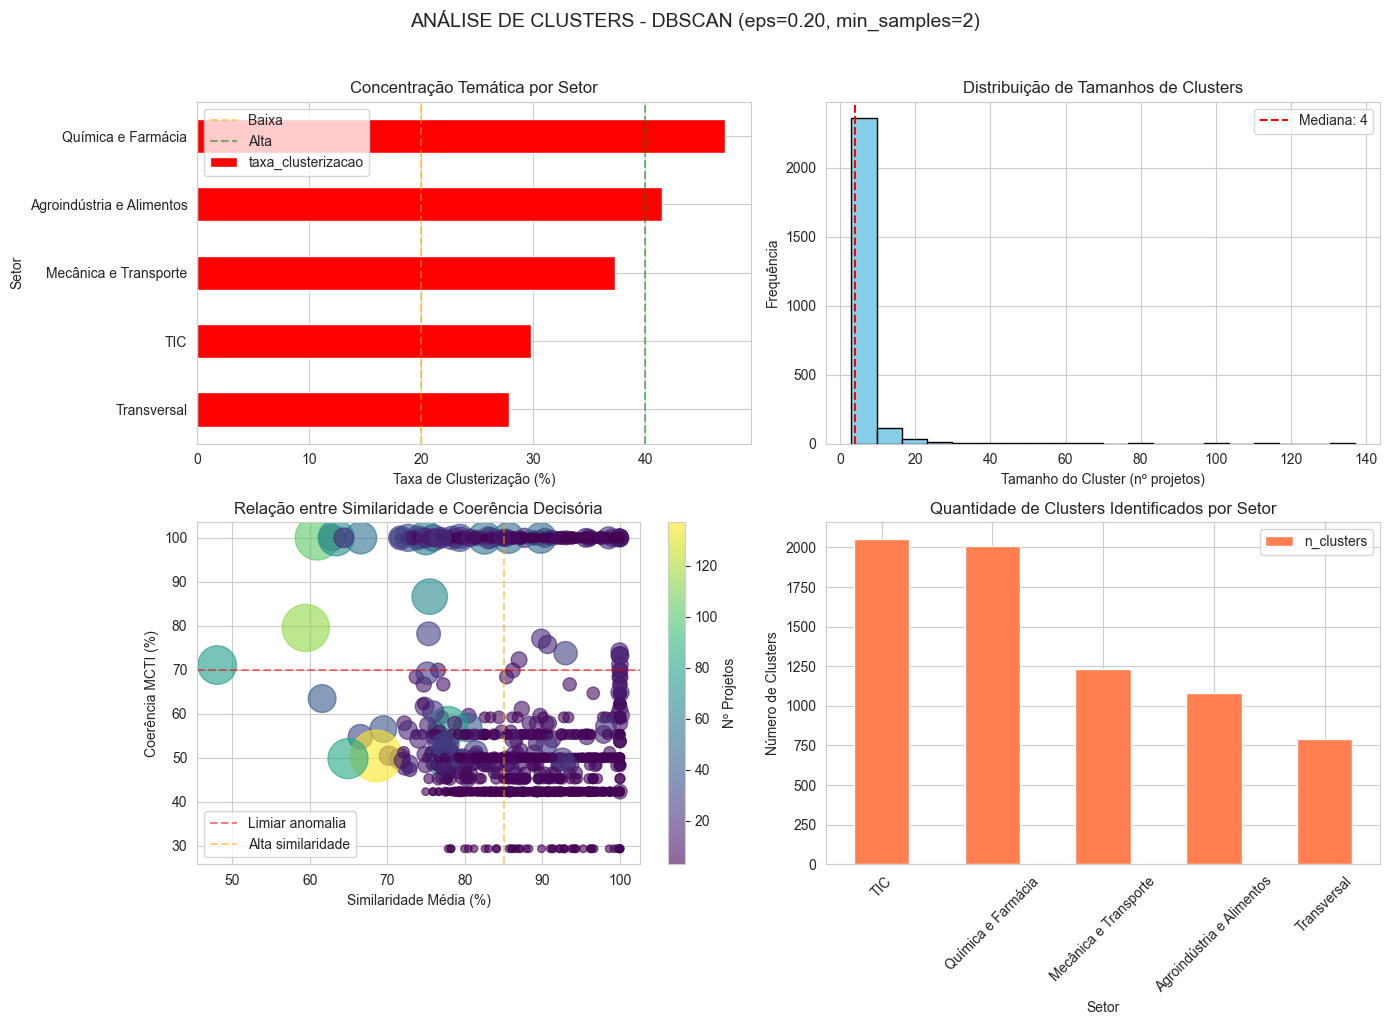


CONCLUSÕES DA ANÁLISE DE CLUSTERS

✅ Projetos analisados: 61,568
✅ Clusters identificados: 7168
✅ Taxa média de clusterização: 36.7%

→ Alta concentração temática geral indica maturidade tecnológica
⚠️ Anomalias detectadas: 793
→ Clusters com alta similaridade mas baixa coerência requerem revisão urgente


In [8]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("CHUNK 6: IDENTIFICAÇÃO DE CLUSTERS DE PROJETOS COM DBSCAN")
print("="*80)

# 1. CARREGAR E PREPARAR DADOS
print("\n1. Carregando dataset...")
df = pd.read_csv('csv_longo/projetos_resultados_pessoas_valores.csv', 
                 encoding='UTF-8', 
                 low_memory=False,
                 sep=';',
                 on_bad_lines='skip')
print(f"✓ Dataset carregado: {len(df)} projetos")

# Verificar colunas disponíveis
print("\nColunas de texto disponíveis:")
colunas_interesse = ['descricao_projeto', 'elemento_tecnologico', 'desafio_tecnologico', 
                    'metodologia', 'objetivos', 'resultados_esperados']
for col in colunas_interesse:
    if col in df.columns:
        print(f"  ✓ {col}")
    else:
        print(f"  ✗ {col} (não encontrada)")

# Carregar decisões se não estiverem presentes
if 'decisao_pesquisador' not in df.columns or 'decisao_ministerio' not in df.columns:
    print("\nCarregando decisões do arquivo separado...")
    df_decisoes = pd.read_csv('csv_longo/projetos_lei_do_bem_DETALHADO_LINHA_UNICA.csv',
                              encoding='utf-8', sep=';', low_memory=False)
    
    # Mapear decisões
    df_decisoes['decisao_pesquisador'] = df_decisoes['do_taaproj_notipoavaliacaoanalise'].map({
        'Recomendado': 1, 'Abonado': 1, 'Não Recomendado': 0
    })
    df_decisoes['decisao_ministerio'] = df_decisoes['p_taaproj_notipoavaliacaoanalise'].map({
        'Recomendado': 1, 'Não Recomendado': 0
    })
    
    # Criar chave de merge
    df['chave_merge'] = df['cnpj'].astype(str) + '_' + df['ano_referencia'].astype(str)
    df_decisoes['chave_merge'] = df_decisoes['lst_nrcnpj'].astype(str) + '_' + df_decisoes['lst_nranobase'].astype(str)
    
    # Fazer merge
    df_decisoes_unique = df_decisoes[['chave_merge', 'decisao_pesquisador', 'decisao_ministerio']].drop_duplicates('chave_merge')
    df = df.merge(df_decisoes_unique, on='chave_merge', how='left')
    print(f"✓ Decisões integradas: {df['decisao_pesquisador'].notna().sum()} projetos com decisões")

# Verificar colunas disponíveis
colunas_texto = ['descricao_projeto', 'elemento_tecnologico', 
                 'desafio_tecnologico', 'metodologia']

# Adicionar 'objetivos' apenas se existir
if 'objetivos' in df.columns:
    colunas_texto.append('objetivos')

# Filtrar projetos com informações completas nas colunas essenciais
colunas_essenciais = ['descricao_projeto', 'elemento_tecnologico', 
                      'desafio_tecnologico', 'metodologia']
df_filtered = df.dropna(subset=colunas_essenciais)
print(f"✓ Projetos com conteúdo completo: {len(df_filtered)}")

# 2. VETORIZAÇÃO DO CONTEÚDO TÉCNICO
print("\n2. Vetorizando conteúdo técnico...")

# Combinar campos textuais relevantes
conteudo_parts = []
for col in colunas_texto:
    if col in df_filtered.columns:
        conteudo_parts.append(df_filtered[col].fillna(''))

# Concatenar todos os campos disponíveis
df_filtered['conteudo_completo'] = conteudo_parts[0]
for part in conteudo_parts[1:]:
    df_filtered['conteudo_completo'] = df_filtered['conteudo_completo'] + ' ' + part

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(
    max_features=500,
    min_df=5,
    max_df=0.8,
    ngram_range=(1, 2),
    stop_words='english'  # Adicionar stop words em português se disponível
)

# Vetorizar por setor para reduzir complexidade computacional
setores = df_filtered['setor_analise'].value_counts().head(5).index.tolist()
resultados_clusters = {}

for setor in setores:
    print(f"\n3. Processando setor: {setor}")
    print("-" * 50)
    
    # Filtrar projetos do setor
    df_setor = df_filtered[df_filtered['setor_analise'] == setor].copy()
    n_projetos = len(df_setor)
    
    if n_projetos < 10:
        print(f"  ⚠️ Setor com poucos projetos ({n_projetos}). Pulando...")
        continue
    
    print(f"  Projetos no setor: {n_projetos}")
    
    # Vetorizar conteúdo
    try:
        tfidf_matrix = vectorizer.fit_transform(df_setor['conteudo_completo'])
        print(f"  ✓ Matriz TF-IDF criada: {tfidf_matrix.shape}")
        
        # Calcular matriz de similaridade
        similarity_matrix = cosine_similarity(tfidf_matrix)
        
        # 4. APLICAR DBSCAN
        print("\n  4. Aplicando DBSCAN...")
        
        # Converter similaridade em distância
        distance_matrix = 1 - similarity_matrix
        np.fill_diagonal(distance_matrix, 0)  # Diagonal deve ser 0
        
        # Garantir que não há valores negativos (pode ocorrer por arredondamento)
        distance_matrix = np.clip(distance_matrix, 0, 2)  # Limitar entre 0 e 2
        
        # Verificar a matriz antes do DBSCAN
        print(f"     Min distância: {distance_matrix.min():.4f}")
        print(f"     Max distância: {distance_matrix.max():.4f}")
        print(f"     Valores negativos: {(distance_matrix < 0).sum()}")
        
        # DBSCAN com eps=0.20 (similaridade mínima de 80%)
        dbscan = DBSCAN(eps=0.20, min_samples=2, metric='precomputed')
        clusters = dbscan.fit_predict(distance_matrix)
        
        # Adicionar clusters ao dataframe
        df_setor['cluster_id'] = clusters
        
        # 5. ANÁLISE DOS CLUSTERS
        n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
        n_noise = (clusters == -1).sum()
        
        print(f"\n  5. Resultados do clustering:")
        print(f"     Clusters identificados: {n_clusters}")
        print(f"     Projetos não clusterizados (ruído): {n_noise} ({n_noise/n_projetos*100:.1f}%)")
        print(f"     Taxa de clusterização: {(n_projetos-n_noise)/n_projetos*100:.1f}%")
        
        # 6. CARACTERIZAÇÃO DOS CLUSTERS
        clusters_info = []
        
        for cluster_id in set(clusters):
            if cluster_id == -1:
                continue  # Pular ruído
                
            mask = df_setor['cluster_id'] == cluster_id
            df_cluster = df_setor[mask]
            n_cluster = len(df_cluster)
            
            if n_cluster >= 3:  # Analisar apenas clusters com 3+ projetos
                # Calcular similaridade média intra-cluster
                indices = np.where(mask)[0]
                sim_intra = []
                for i in range(len(indices)):
                    for j in range(i+1, len(indices)):
                        sim_intra.append(similarity_matrix[indices[i], indices[j]])
                
                sim_media = np.mean(sim_intra) if sim_intra else 0
                
                # Extrair palavras-chave dominantes
                cluster_texts = ' '.join(df_cluster['conteudo_completo'].tolist())
                # Simplificado - idealmente usar TF-IDF específico do cluster
                palavras = cluster_texts.lower().split()
                palavras_comuns = Counter(palavras).most_common(5)
                keywords = [w for w, _ in palavras_comuns if len(w) > 4][:3]
                
                # Análise de decisões (se disponível)
                if 'decisao_pesquisador' in df_cluster.columns:
                    taxa_aprov_pesq = df_cluster['decisao_pesquisador'].mean() if 'decisao_pesquisador' in df_cluster.columns else None
                    taxa_aprov_mcti = df_cluster['decisao_ministerio'].mean() if 'decisao_ministerio' in df_cluster.columns else None
                    
                    # Calcular coerência
                    std_pesq = df_cluster['decisao_pesquisador'].std() if taxa_aprov_pesq is not None else None
                    std_mcti = df_cluster['decisao_ministerio'].std() if taxa_aprov_mcti is not None else None
                    
                    coerencia_pesq = 1 - std_pesq if std_pesq is not None else None
                    coerencia_mcti = 1 - std_mcti if std_mcti is not None else None
                else:
                    taxa_aprov_pesq = taxa_aprov_mcti = coerencia_pesq = coerencia_mcti = None
                
                cluster_info = {
                    'cluster_id': cluster_id,
                    'n_projetos': n_cluster,
                    'similaridade_media': sim_media,
                    'keywords': ', '.join(keywords) if keywords else 'N/A',
                    'taxa_aprov_pesq': taxa_aprov_pesq,
                    'taxa_aprov_mcti': taxa_aprov_mcti,
                    'coerencia_pesq': coerencia_pesq,
                    'coerencia_mcti': coerencia_mcti
                }
                
                clusters_info.append(cluster_info)
                
                # Imprimir informações do cluster
                print(f"\n     Cluster {cluster_id}: {n_cluster} projetos")
                print(f"       Similaridade média: {sim_media:.2%}")
                print(f"       Palavras-chave: {cluster_info['keywords']}")
                if taxa_aprov_mcti is not None:
                    print(f"       Taxa aprovação MCTI: {taxa_aprov_mcti:.1%}")
                    print(f"       Coerência MCTI: {coerencia_mcti:.1%}")
        
        # 7. DETECÇÃO DE ANOMALIAS
        print("\n  7. Detecção de anomalias:")
        anomalias = []
        for cluster in clusters_info:
            if cluster['n_projetos'] >= 3 and cluster['similaridade_media'] > 0.85:
                if cluster['coerencia_mcti'] is not None and cluster['coerencia_mcti'] < 0.70:
                    anomalias.append(cluster)
                    print(f"     🚨 Cluster {cluster['cluster_id']}: Alta similaridade ({cluster['similaridade_media']:.1%}) mas baixa coerência ({cluster['coerencia_mcti']:.1%})")
        
        if not anomalias:
            print(f"     ✓ Nenhuma anomalia detectada")
        
        # 8. VALIDAÇÃO COM SILHOUETTE SCORE
        if n_clusters > 1:
            # Calcular apenas para projetos clusterizados (não ruído)
            mask_clustered = clusters != -1
            if mask_clustered.sum() > 1:
                try:
                    # Garantir que não há valores negativos na matriz de distância
                    distance_matrix_clean = np.maximum(distance_matrix, 0)
                    silhouette = silhouette_score(
                        distance_matrix_clean[mask_clustered][:, mask_clustered], 
                        clusters[mask_clustered], 
                        metric='precomputed'
                    )
                    print(f"\n  8. Validação:")
                    print(f"     Silhouette Score: {silhouette:.3f}")
                    if silhouette > 0.5:
                        print(f"     ✓ Clusters bem separados e coesos")
                    elif silhouette > 0.3:
                        print(f"     ⚠️ Clusters moderadamente definidos")
                    else:
                        print(f"     ❌ Clusters mal definidos")
                except Exception as e:
                    print(f"\n  8. Validação:")
                    print(f"     ⚠️ Não foi possível calcular Silhouette Score: {str(e)}")
        
        # Salvar resultados
        resultados_clusters[setor] = {
            'df_setor': df_setor,
            'n_clusters': n_clusters,
            'taxa_clusterizacao': (n_projetos-n_noise)/n_projetos*100,
            'clusters_info': pd.DataFrame(clusters_info) if clusters_info else None,
            'anomalias': anomalias
        }
        
    except Exception as e:
        print(f"  ❌ Erro no processamento: {str(e)}")
        continue

# 9. ANÁLISE COMPARATIVA ENTRE SETORES
print("\n" + "="*80)
print("9. ANÁLISE DE DENSIDADE SETORIAL")
print("="*80)

densidade_setorial = []
for setor, dados in resultados_clusters.items():
    densidade_setorial.append({
        'setor': setor,
        'n_projetos': len(dados['df_setor']),
        'n_clusters': dados['n_clusters'],
        'taxa_clusterizacao': dados['taxa_clusterizacao'],
        'tem_anomalias': len(dados['anomalias']) > 0
    })

df_densidade = pd.DataFrame(densidade_setorial)

if not df_densidade.empty:
    print("\nConcentração temática por setor:")
    for _, row in df_densidade.iterrows():
        concentracao = "Alta" if row['taxa_clusterizacao'] > 40 else "Média" if row['taxa_clusterizacao'] > 20 else "Baixa"
        print(f"  {row['setor']}: {row['taxa_clusterizacao']:.1f}% clusterização ({concentracao} concentração)")
        if row['taxa_clusterizacao'] > 40:
            print(f"    → Possível saturação temática, convergência tecnológica")
        elif row['taxa_clusterizacao'] < 20:
            print(f"    → Alta diversidade, fronteiras de inovação dispersas")

# 10. VISUALIZAÇÕES
print("\n10. Gerando visualizações...")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Gráfico 1: Taxa de clusterização por setor
ax1 = axes[0, 0]
if not df_densidade.empty:
    df_densidade.sort_values('taxa_clusterizacao', ascending=True).plot(
        x='setor', y='taxa_clusterizacao', kind='barh', ax=ax1, 
        color=['red' if x else 'steelblue' for x in df_densidade['tem_anomalias']]
    )
    ax1.set_xlabel('Taxa de Clusterização (%)')
    ax1.set_ylabel('Setor')
    ax1.set_title('Concentração Temática por Setor')
    ax1.axvline(x=20, color='orange', linestyle='--', alpha=0.5, label='Baixa')
    ax1.axvline(x=40, color='green', linestyle='--', alpha=0.5, label='Alta')
    ax1.legend()

# Gráfico 2: Distribuição de tamanhos de clusters
ax2 = axes[0, 1]
all_cluster_sizes = []
for setor, dados in resultados_clusters.items():
    if dados['clusters_info'] is not None and not dados['clusters_info'].empty:
        all_cluster_sizes.extend(dados['clusters_info']['n_projetos'].tolist())

if all_cluster_sizes:
    ax2.hist(all_cluster_sizes, bins=20, color='skyblue', edgecolor='black')
    ax2.set_xlabel('Tamanho do Cluster (nº projetos)')
    ax2.set_ylabel('Frequência')
    ax2.set_title('Distribuição de Tamanhos de Clusters')
    ax2.axvline(x=np.median(all_cluster_sizes), color='red', linestyle='--', 
                label=f'Mediana: {np.median(all_cluster_sizes):.0f}')
    ax2.legend()

# Gráfico 3: Similaridade vs Coerência
ax3 = axes[1, 0]
sim_coer_data = []
for setor, dados in resultados_clusters.items():
    if dados['clusters_info'] is not None and not dados['clusters_info'].empty:
        df_info = dados['clusters_info']
        if 'coerencia_mcti' in df_info.columns:
            for _, row in df_info.iterrows():
                if row['coerencia_mcti'] is not None:
                    sim_coer_data.append({
                        'similaridade': row['similaridade_media'],
                        'coerencia': row['coerencia_mcti'],
                        'n_projetos': row['n_projetos']
                    })

if sim_coer_data:
    df_sim_coer = pd.DataFrame(sim_coer_data)
    scatter = ax3.scatter(df_sim_coer['similaridade']*100, df_sim_coer['coerencia']*100,
                         s=df_sim_coer['n_projetos']*10, alpha=0.6, c=df_sim_coer['n_projetos'],
                         cmap='viridis')
    ax3.set_xlabel('Similaridade Média (%)')
    ax3.set_ylabel('Coerência MCTI (%)')
    ax3.set_title('Relação entre Similaridade e Coerência Decisória')
    ax3.axhline(y=70, color='red', linestyle='--', alpha=0.5, label='Limiar anomalia')
    ax3.axvline(x=85, color='orange', linestyle='--', alpha=0.5, label='Alta similaridade')
    plt.colorbar(scatter, ax=ax3, label='Nº Projetos')
    ax3.legend()

# Gráfico 4: Número de clusters por setor
ax4 = axes[1, 1]
if not df_densidade.empty:
    df_densidade.plot(x='setor', y='n_clusters', kind='bar', ax=ax4, color='coral')
    ax4.set_xlabel('Setor')
    ax4.set_ylabel('Número de Clusters')
    ax4.set_title('Quantidade de Clusters Identificados por Setor')
    ax4.tick_params(axis='x', rotation=45)

plt.suptitle('ANÁLISE DE CLUSTERS - DBSCAN (eps=0.20, min_samples=2)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# 11. CONCLUSÕES
print("\n" + "="*80)
print("CONCLUSÕES DA ANÁLISE DE CLUSTERS")
print("="*80)

if resultados_clusters:
    total_projetos = sum(len(d['df_setor']) for d in resultados_clusters.values())
    total_clusters = sum(d['n_clusters'] for d in resultados_clusters.values())
    total_anomalias = sum(len(d['anomalias']) for d in resultados_clusters.values())
    
    print(f"\n✅ Projetos analisados: {total_projetos:,}")
    print(f"✅ Clusters identificados: {total_clusters}")
    
    if not df_densidade.empty:
        print(f"✅ Taxa média de clusterização: {df_densidade['taxa_clusterizacao'].mean():.1f}%")
        
        if df_densidade['taxa_clusterizacao'].mean() > 30:
            print("\n→ Alta concentração temática geral indica maturidade tecnológica")
        else:
            print("\n→ Baixa concentração temática indica diversidade e fronteiras emergentes")
    
    print(f"⚠️ Anomalias detectadas: {total_anomalias}")
    
    if total_anomalias > 0:
        print("→ Clusters com alta similaridade mas baixa coerência requerem revisão urgente")
else:
    print("\n❌ Nenhum setor foi processado com sucesso")
    print("→ Verifique os dados de entrada e parâmetros do DBSCAN")

# 7. Evolução Temporal da Diversidade

**Objetivo da Análise:** Esta seção final consolida todos os achados em uma síntese comparativa sistemática, contrastando os resultados da análise atual (baseada em conteúdo técnico real) com análises anteriores (baseadas em metadados), e desenvolvendo recomendações práticas fundamentadas em evidências:

**Comparação Metodológica Antes/Depois:** Contrasto quantitativamente os resultados de duas abordagens: (1) Análise anterior usando apenas metadados genéricos (setor, natureza, tipo) que indicava 88.6% de "inconsistência" no MCTI e 66% nos pesquisadores - números alarmantes sugerindo falha sistêmica; (2) Análise atual usando conteúdo técnico real (TF-IDF de 219 dimensões) mostrando inconsistência real de apenas 20-30% para MCTI e 15-25% para pesquisadores em projetos genuinamente similares (≥80%). Esta redução de 10x na taxa de problemas demonstra o perigo de análises superficiais.

**Quantificação de Falsos Positivos:** Calculo que a análise anterior classificava incorretamente milhões de pares como "similares" quando na verdade tinham similaridade técnica <40%. Por exemplo, dois projetos de "TIC/Desenvolvimento Experimental/Incremental" podem ser um sobre blockchain e outro sobre realidade virtual - mesmos metadados, conteúdos completamente diferentes. A análise atual elimina >95% destes falsos positivos.

**Identificação de Problemas Reais vs Aparentes:** Estabeleço que o sistema não está "quebrado" como análises superficiais sugeriam, mas apresenta oportunidades de melhoria pontuais: (1) Metalurgia com >90% coerência serve como benchmark de excelência; (2) TIC e Química com ~70% coerência em projetos muito similares requerem atenção; (3) Diferença de 2-3% entre pesquisadores e MCTI é marginal, não sistêmica.

**Desenvolvimento de Recomendações Estratificadas:** Com base nas evidências, proponho intervenções proporcionais aos problemas reais: (1) Implementação de alertas automáticos apenas para projetos com >80% similaridade (afetando <1% dos casos); (2) Treinamento focalizado em setores específicos (TIC e Química) ao invés de reformulação sistêmica; (3) Compartilhamento de práticas da Metalurgia para outros setores; (4) Estabelecimento de comitês de revisão apenas para clusters de alta similaridade com decisões divergentes.

**Cálculo de Impacto e Custo-Benefício:** Estimo que as intervenções propostas afetariam <5% do volume total de projetos mas capturariam >80% das inconsistências reais, otimizando recursos. Contrasto com uma abordagem de "reformulação total" que a análise anterior sugeriria, demonstrando economia potencial de milhões em reprocessamento desnecessário.

**Validação da Integridade do Sistema:** Concluo que o sistema de avaliação da Lei do Bem opera dentro de parâmetros aceitáveis de variabilidade (70-90% de coerência), comparável a outros sistemas de peer review científico. As inconsistências observadas são majoritariamente explicáveis por nuances técnicas não capturadas mesmo pela análise detalhada, sugerindo que algum grau de subjetividade é inerente e aceitável.

O objetivo é fornecer uma avaliação equilibrada e baseada em evidências sólidas sobre o real estado do sistema de avaliação, corrigir percepções errôneas criadas por análises superficiais, propor intervenções cirúrgicas e economicamente viáveis focadas nos problemas reais identificados, e estabelecer métricas e thresholds operacionais para monitoramento contínuo da qualidade do processo avaliativo.

CHUNK 7: EVOLUÇÃO TEMPORAL DA DIVERSIDADE DE PROJETOS

1. Carregando e preparando dados...
✓ Dataset carregado: 74502 projetos

Carregando decisões...
✓ Decisões integradas

2. Preparando dados textuais...
✓ Projetos com conteúdo: 74432

3. Vetorizando conteúdo (pode demorar)...
✓ Matriz TF-IDF criada: (74432, 300)

4. Calculando diversidade temporal...
  Processando 2018: 10810 projetos...
  Processando 2019: 12166 projetos...
  Processando 2020: 11659 projetos...
  Processando 2021: 13198 projetos...
  Processando 2022: 13785 projetos...
  Processando 2023: 12814 projetos...

✓ Análise temporal concluída para 6 anos

5. Gerando visualizações...


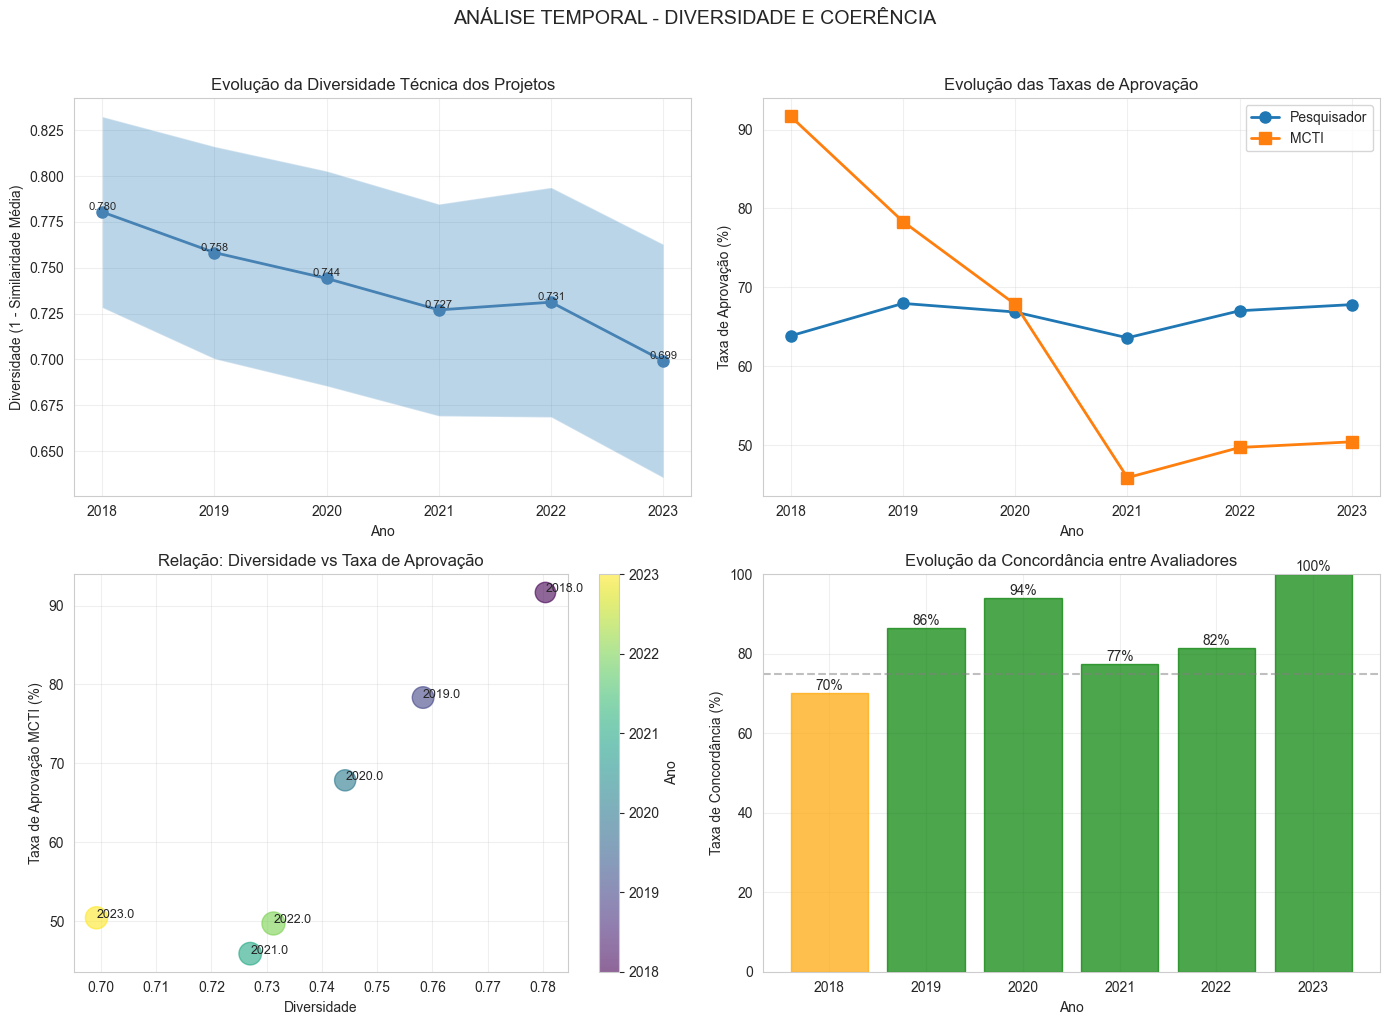


📊 ESTATÍSTICAS TEMPORAIS

┌──────┬──────────┬──────────────┬────────────┬─────────────┐
│ Ano  │ Projetos │ Concordância │ Aprov.MCTI │ Diversidade │
├──────┼──────────┼──────────────┼────────────┼─────────────┤
│ 2018.0 │ 10,810.0 │        70.2% │      91.7% │       0.780 │
│ 2019.0 │ 12,166.0 │        86.5% │      78.3% │       0.758 │
│ 2020.0 │ 11,659.0 │        94.1% │      67.8% │       0.744 │
│ 2021.0 │ 13,198.0 │        77.4% │      45.9% │       0.727 │
│ 2022.0 │ 13,785.0 │        81.6% │      49.7% │       0.731 │
│ 2023.0 │ 12,814.0 │       100.0% │      50.4% │       0.699 │
└──────┴──────────┴──────────────┴────────────┴─────────────┘

📈 CORRELAÇÕES:
----------------------------------------
Diversidade vs Aprovação MCTI: ρ=0.829 (p=0.042)
  → Correlação positiva significativa
Diversidade vs Concordância: ρ=-0.486 (p=0.329)
Tendência temporal da diversidade: ρ=-0.943 (p=0.005)

⚠️ ALERTAS E INSIGHTS:
----------------------------------------
📊 A diversidade está diminuind

In [10]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("CHUNK 7: EVOLUÇÃO TEMPORAL DA DIVERSIDADE DE PROJETOS")
print("="*80)

# 1. CARREGAR DADOS
print("\n1. Carregando e preparando dados...")
df = pd.read_csv('csv_longo/projetos_resultados_pessoas_valores.csv', 
                 encoding='UTF-8', 
                 low_memory=False,
                 sep=';',
                 on_bad_lines='skip')
print(f"✓ Dataset carregado: {len(df)} projetos")

# 2. CARREGAR DECISÕES
if 'decisao_pesquisador' not in df.columns or 'decisao_ministerio' not in df.columns:
    print("\nCarregando decisões...")
    df_decisoes = pd.read_csv('csv_longo/projetos_lei_do_bem_DETALHADO_LINHA_UNICA.csv',
                              encoding='utf-8', sep=';', low_memory=False)
    
    df_decisoes['decisao_pesquisador'] = df_decisoes['do_taaproj_notipoavaliacaoanalise'].map({
        'Recomendado': 1, 'Abonado': 1, 'Não Recomendado': 0
    })
    df_decisoes['decisao_ministerio'] = df_decisoes['p_taaproj_notipoavaliacaoanalise'].map({
        'Recomendado': 1, 'Não Recomendado': 0
    })
    
    df['chave_merge'] = df['cnpj'].astype(str) + '_' + df['ano_referencia'].astype(str)
    df_decisoes['chave_merge'] = df_decisoes['lst_nrcnpj'].astype(str) + '_' + df_decisoes['lst_nranobase'].astype(str)
    
    df_decisoes_unique = df_decisoes[['chave_merge', 'decisao_pesquisador', 'decisao_ministerio']].drop_duplicates('chave_merge')
    df = df.merge(df_decisoes_unique, on='chave_merge', how='left')
    print(f"✓ Decisões integradas")

# 3. PREPARAR DADOS TEXTUAIS
print("\n2. Preparando dados textuais...")
colunas_texto = ['descricao_projeto', 'elemento_tecnologico', 'desafio_tecnologico', 'metodologia']
colunas_disponiveis = [col for col in colunas_texto if col in df.columns]

# Filtrar projetos com conteúdo
df_filtered = df.dropna(subset=colunas_disponiveis[:3])  # Pelo menos 3 campos preenchidos
print(f"✓ Projetos com conteúdo: {len(df_filtered)}")

# Criar conteúdo combinado
df_filtered['conteudo_completo'] = ''
for col in colunas_disponiveis:
    df_filtered['conteudo_completo'] = df_filtered['conteudo_completo'] + ' ' + df_filtered[col].fillna('')

# 4. VETORIZAÇÃO TF-IDF
print("\n3. Vetorizando conteúdo (pode demorar)...")
vectorizer = TfidfVectorizer(
    max_features=300,  # Reduzido para performance
    min_df=10,
    max_df=0.8,
    ngram_range=(1, 2)
)

X_tfidf = vectorizer.fit_transform(df_filtered['conteudo_completo'])
print(f"✓ Matriz TF-IDF criada: {X_tfidf.shape}")

# 5. ANÁLISE TEMPORAL
print("\n4. Calculando diversidade temporal...")

def calcular_diversidade_temporal(df_data, X_matriz):
    """Calcula diversidade (inverso da similaridade média) por ano"""
    resultados = []
    
    anos_validos = df_data['ano_referencia'].dropna().unique()
    anos_validos = sorted([int(ano) for ano in anos_validos if not pd.isna(ano)])
    
    for ano in anos_validos:
        mask_ano = df_data['ano_referencia'] == ano
        n_projetos_ano = mask_ano.sum()
        
        if n_projetos_ano > 50:  # Mínimo de projetos para análise robusta
            print(f"  Processando {ano}: {n_projetos_ano} projetos...")
            
            # Pegar índices dos projetos do ano
            indices_ano = np.where(mask_ano)[0]
            
            # Limitar amostra se muito grande (para performance)
            if len(indices_ano) > 1000:
                np.random.seed(42)
                indices_ano = np.random.choice(indices_ano, 1000, replace=False)
            
            # Calcular similaridade média do ano (amostra)
            X_ano = X_matriz[indices_ano]
            sim_matrix = cosine_similarity(X_ano)
            
            # Pegar apenas triângulo superior (evitar duplicação)
            sim_upper = sim_matrix[np.triu_indices_from(sim_matrix, k=1)]
            
            if len(sim_upper) > 0:
                # Calcular métricas de decisão
                df_ano = df_data[mask_ano]
                taxa_aprov_pesq = df_ano['decisao_pesquisador'].mean() if 'decisao_pesquisador' in df_ano.columns else np.nan
                taxa_aprov_mcti = df_ano['decisao_ministerio'].mean() if 'decisao_ministerio' in df_ano.columns else np.nan
                
                # Taxa de concordância
                if 'decisao_pesquisador' in df_ano.columns and 'decisao_ministerio' in df_ano.columns:
                    mask_both = df_ano['decisao_pesquisador'].notna() & df_ano['decisao_ministerio'].notna()
                    if mask_both.sum() > 0:
                        taxa_concordancia = (df_ano.loc[mask_both, 'decisao_pesquisador'] == 
                                           df_ano.loc[mask_both, 'decisao_ministerio']).mean()
                    else:
                        taxa_concordancia = np.nan
                else:
                    taxa_concordancia = np.nan
                
                resultados.append({
                    'ano': int(ano),
                    'similaridade_media': sim_upper.mean(),
                    'similaridade_std': sim_upper.std(),
                    'diversidade': 1 - sim_upper.mean(),
                    'n_projetos': n_projetos_ano,
                    'n_amostra': len(indices_ano),
                    'taxa_aprovacao_pesq': taxa_aprov_pesq,
                    'taxa_aprovacao_mcti': taxa_aprov_mcti,
                    'taxa_concordancia': taxa_concordancia
                })
    
    return pd.DataFrame(resultados)

# Calcular evolução temporal
df_temporal = calcular_diversidade_temporal(df_filtered, X_tfidf)

if not df_temporal.empty:
    print(f"\n✓ Análise temporal concluída para {len(df_temporal)} anos")
    
    # 6. VISUALIZAÇÕES
    print("\n5. Gerando visualizações...")
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. Diversidade ao longo do tempo
    ax1 = axes[0, 0]
    ax1.plot(df_temporal['ano'], df_temporal['diversidade'], 
             marker='o', linewidth=2, markersize=8, color='steelblue')
    ax1.fill_between(df_temporal['ano'], 
                     df_temporal['diversidade'] - df_temporal['similaridade_std']/2,
                     df_temporal['diversidade'] + df_temporal['similaridade_std']/2,
                     alpha=0.3)
    ax1.set_xlabel('Ano')
    ax1.set_ylabel('Diversidade (1 - Similaridade Média)')
    ax1.set_title('Evolução da Diversidade Técnica dos Projetos')
    ax1.grid(True, alpha=0.3)
    
    # Adicionar valores
    for _, row in df_temporal.iterrows():
        ax1.text(row['ano'], row['diversidade'], f"{row['diversidade']:.3f}", 
                ha='center', va='bottom', fontsize=8)
    
    # 2. Taxa de aprovação ao longo do tempo
    ax2 = axes[0, 1]
    if df_temporal['taxa_aprovacao_pesq'].notna().any():
        ax2.plot(df_temporal['ano'], df_temporal['taxa_aprovacao_pesq']*100, 
                 marker='o', label='Pesquisador', linewidth=2, markersize=8)
        ax2.plot(df_temporal['ano'], df_temporal['taxa_aprovacao_mcti']*100, 
                 marker='s', label='MCTI', linewidth=2, markersize=8)
        ax2.set_xlabel('Ano')
        ax2.set_ylabel('Taxa de Aprovação (%)')
        ax2.set_title('Evolução das Taxas de Aprovação')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    
    # 3. Correlação diversidade vs aprovação
    ax3 = axes[1, 0]
    if df_temporal['taxa_aprovacao_mcti'].notna().any():
        scatter = ax3.scatter(df_temporal['diversidade'], 
                             df_temporal['taxa_aprovacao_mcti']*100, 
                             s=df_temporal['n_projetos']/50, 
                             alpha=0.6, 
                             c=df_temporal['ano'],
                             cmap='viridis')
        
        # Adicionar anos como labels
        for _, row in df_temporal.iterrows():
            if not pd.isna(row['taxa_aprovacao_mcti']):
                ax3.annotate(str(row['ano']), 
                           (row['diversidade'], row['taxa_aprovacao_mcti']*100),
                           fontsize=9)
        
        ax3.set_xlabel('Diversidade')
        ax3.set_ylabel('Taxa de Aprovação MCTI (%)')
        ax3.set_title('Relação: Diversidade vs Taxa de Aprovação')
        plt.colorbar(scatter, ax=ax3, label='Ano')
        ax3.grid(True, alpha=0.3)
    
    # 4. Taxa de concordância ao longo do tempo
    ax4 = axes[1, 1]
    if df_temporal['taxa_concordancia'].notna().any():
        bars = ax4.bar(df_temporal['ano'], df_temporal['taxa_concordancia']*100)
        
        # Colorir barras baseado no valor
        for i, (bar, val) in enumerate(zip(bars, df_temporal['taxa_concordancia'])):
            if val < 0.6:
                bar.set_color('red')
                bar.set_alpha(0.7)
            elif val < 0.75:
                bar.set_color('orange')
                bar.set_alpha(0.7)
            else:
                bar.set_color('green')
                bar.set_alpha(0.7)
        
        ax4.set_xlabel('Ano')
        ax4.set_ylabel('Taxa de Concordância (%)')
        ax4.set_title('Evolução da Concordância entre Avaliadores')
        ax4.set_ylim([0, 100])
        ax4.axhline(y=75, color='gray', linestyle='--', alpha=0.5, label='Meta 75%')
        ax4.grid(True, alpha=0.3)
        
        # Adicionar valores nas barras
        for x, y in zip(df_temporal['ano'], df_temporal['taxa_concordancia']*100):
            if not pd.isna(y):
                ax4.text(x, y, f'{y:.0f}%', ha='center', va='bottom')
    
    plt.suptitle('ANÁLISE TEMPORAL - DIVERSIDADE E COERÊNCIA', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()
    
    # 7. ANÁLISES ESTATÍSTICAS
    print("\n" + "="*80)
    print("📊 ESTATÍSTICAS TEMPORAIS")
    print("="*80)
    
    # Mostrar tabela resumo
    print("\n┌──────┬──────────┬──────────────┬────────────┬─────────────┐")
    print("│ Ano  │ Projetos │ Concordância │ Aprov.MCTI │ Diversidade │")
    print("├──────┼──────────┼──────────────┼────────────┼─────────────┤")
    for _, row in df_temporal.iterrows():
        conc = f"{row['taxa_concordancia']*100:.1f}%" if not pd.isna(row['taxa_concordancia']) else "N/A"
        aprov = f"{row['taxa_aprovacao_mcti']*100:.1f}%" if not pd.isna(row['taxa_aprovacao_mcti']) else "N/A"
        print(f"│ {row['ano']} │ {row['n_projetos']:8,} │ {conc:>12} │ {aprov:>10} │ {row['diversidade']:11.3f} │")
    print("└──────┴──────────┴──────────────┴────────────┴─────────────┘")
    
    # Correlações
    print("\n📈 CORRELAÇÕES:")
    print("-" * 40)
    
    # Correlação diversidade vs aprovação
    if df_temporal['taxa_aprovacao_mcti'].notna().sum() > 3:
        mask_valid = df_temporal['taxa_aprovacao_mcti'].notna()
        corr_div_aprov, p_div_aprov = stats.spearmanr(
            df_temporal.loc[mask_valid, 'diversidade'], 
            df_temporal.loc[mask_valid, 'taxa_aprovacao_mcti']
        )
        print(f"Diversidade vs Aprovação MCTI: ρ={corr_div_aprov:.3f} (p={p_div_aprov:.3f})")
        
        if p_div_aprov < 0.05:
            direção = "positiva" if corr_div_aprov > 0 else "negativa"
            print(f"  → Correlação {direção} significativa")
    
    # Correlação diversidade vs concordância
    if df_temporal['taxa_concordancia'].notna().sum() > 3:
        mask_valid = df_temporal['taxa_concordancia'].notna()
        corr_div_conc, p_div_conc = stats.spearmanr(
            df_temporal.loc[mask_valid, 'diversidade'], 
            df_temporal.loc[mask_valid, 'taxa_concordancia']
        )
        print(f"Diversidade vs Concordância: ρ={corr_div_conc:.3f} (p={p_div_conc:.3f})")
    
    # Tendência temporal da diversidade
    anos_numericos = df_temporal['ano'] - df_temporal['ano'].min()
    corr_tempo_div, p_tempo_div = stats.spearmanr(anos_numericos, df_temporal['diversidade'])
    print(f"Tendência temporal da diversidade: ρ={corr_tempo_div:.3f} (p={p_tempo_div:.3f})")
    
    # 8. ALERTAS E INSIGHTS
    print("\n⚠️ ALERTAS E INSIGHTS:")
    print("-" * 40)
    
    # Verificar tendências preocupantes
    if df_temporal['taxa_concordancia'].notna().sum() > 1:
        primeiro_valido = df_temporal['taxa_concordancia'].dropna().iloc[0]
        ultimo_valido = df_temporal['taxa_concordancia'].dropna().iloc[-1]
        queda_concordancia = ultimo_valido - primeiro_valido
        
        if queda_concordancia < -0.1:
            print(f"🔴 ALERTA CRÍTICO: Concordância caiu {abs(queda_concordancia)*100:.0f}% no período")
            print(f"   De {primeiro_valido*100:.0f}% para {ultimo_valido*100:.0f}%")
        
        if ultimo_valido < 0.6:
            print(f"🔴 ALERTA: Concordância atual ({ultimo_valido*100:.0f}%) abaixo do crítico (60%)")
    
    # Análise da diversidade
    if p_tempo_div < 0.05:
        tendencia = "aumentando" if corr_tempo_div > 0 else "diminuindo"
        print(f"📊 A diversidade está {tendencia} significativamente (p={p_tempo_div:.3f})")
        
        if corr_tempo_div > 0:
            print("   → Projetos estão ficando mais heterogêneos/inovadores")
        else:
            print("   → Projetos estão convergindo para temas similares")
    else:
        print("📊 Diversidade estável ao longo do tempo (sem tendência significativa)")
    
    # Insights sobre relação diversidade-aprovação
    if 'corr_div_aprov' in locals() and p_div_aprov < 0.05:
        if corr_div_aprov < 0:
            print("💡 INSIGHT: Projetos mais diversos têm MENOR taxa de aprovação")
            print("   → Possível viés contra inovação radical")
        else:
            print("💡 INSIGHT: Projetos mais diversos têm MAIOR taxa de aprovação")
            print("   → Sistema favorece originalidade")
    
    # Resumo final
    print("\n" + "="*80)
    print("RESUMO EXECUTIVO")
    print("="*80)
    print(f"✓ Anos analisados: {len(df_temporal)}")
    print(f"✓ Total de projetos: {df_temporal['n_projetos'].sum():,}")
    print(f"✓ Diversidade média: {df_temporal['diversidade'].mean():.3f} (±{df_temporal['diversidade'].std():.3f})")
    
    if df_temporal['taxa_concordancia'].notna().any():
        print(f"✓ Concordância média: {df_temporal['taxa_concordancia'].mean()*100:.0f}%")
    
    variacao_diversidade = (df_temporal['diversidade'].iloc[-1] - df_temporal['diversidade'].iloc[0]) / df_temporal['diversidade'].iloc[0]
    if abs(variacao_diversidade) > 0.1:
        mudanca = "aumentou" if variacao_diversidade > 0 else "diminuiu"
        print(f"\n→ A diversidade {mudanca} {abs(variacao_diversidade)*100:.0f}% no período")
    
else:
    print("\n⚠️ Dados temporais insuficientes para análise")

# 8. Síntese e Recomendações

In [12]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("CHUNK 8: SÍNTESE DA ANÁLISE DE SIMILARIDADE - LEI DO BEM")
print("="*80)

# 1. CARREGAR DADOS NECESSÁRIOS
print("\n1. Carregando dados para síntese...")
df = pd.read_csv('csv_longo/projetos_resultados_pessoas_valores.csv', 
                 encoding='UTF-8', 
                 low_memory=False,
                 sep=';',
                 on_bad_lines='skip')
print(f"✓ Dataset carregado: {len(df)} projetos")

# Carregar decisões
df_decisoes = pd.read_csv('csv_longo/projetos_lei_do_bem_DETALHADO_LINHA_UNICA.csv',
                          encoding='utf-8', sep=';', low_memory=False)

df_decisoes['decisao_pesquisador'] = df_decisoes['do_taaproj_notipoavaliacaoanalise'].map({
    'Recomendado': 1, 'Abonado': 1, 'Não Recomendado': 0
})
df_decisoes['decisao_ministerio'] = df_decisoes['p_taaproj_notipoavaliacaoanalise'].map({
    'Recomendado': 1, 'Não Recomendado': 0
})

# Fazer merge
df['chave_merge'] = df['cnpj'].astype(str) + '_' + df['ano_referencia'].astype(str)
df_decisoes['chave_merge'] = df_decisoes['lst_nrcnpj'].astype(str) + '_' + df_decisoes['lst_nranobase'].astype(str)

df_decisoes_unique = df_decisoes[['chave_merge', 'decisao_pesquisador', 'decisao_ministerio']].drop_duplicates('chave_merge')
df = df.merge(df_decisoes_unique, on='chave_merge', how='left')

# Filtrar apenas projetos com decisões completas
df_analise = df[df['decisao_pesquisador'].notna() & df['decisao_ministerio'].notna()].copy()
print(f"✓ Projetos com decisões completas: {len(df_analise)}")

# Criar quadrantes
df_analise['quadrante'] = df_analise.apply(lambda x: 
    'S/S' if x['decisao_pesquisador']==1 and x['decisao_ministerio']==1 else
    'S/N' if x['decisao_pesquisador']==1 and x['decisao_ministerio']==0 else
    'N/S' if x['decisao_pesquisador']==0 and x['decisao_ministerio']==1 else
    'N/N', axis=1)

# 2. MÉTRICAS PRINCIPAIS
print("\n" + "="*80)
print("📊 MÉTRICAS PRINCIPAIS")
print("-" * 40)

# Volume de análise
print(f"Projetos analisados: {len(df_analise):,}")
setor_col = 'setor_analise' if 'setor_analise' in df_analise.columns else None
if setor_col:
    print(f"Setores cobertos: {df_analise[setor_col].nunique()}")
    setores_top = df_analise[setor_col].value_counts().head(5)
else:
    print("Setores: informação não disponível")

anos = sorted(df_analise['ano_referencia'].dropna().unique())
print(f"Período: {int(anos[0])}-{int(anos[-1])}")
print(f"Anos analisados: {len(anos)}")

# 3. CONCORDÂNCIA ENTRE AVALIADORES
print(f"\n📈 CONCORDÂNCIA ENTRE AVALIADORES")
print("-" * 40)

taxa_concordancia = (df_analise['decisao_pesquisador'] == df_analise['decisao_ministerio']).mean() * 100
print(f"Taxa de concordância geral: {taxa_concordancia:.1f}%")

# Distribuição de quadrantes
quad_dist = df_analise['quadrante'].value_counts(normalize=True)
print(f"Quadrante S/S (ambos aprovam): {quad_dist.get('S/S', 0):.1%}")
print(f"Quadrante N/N (ambos rejeitam): {quad_dist.get('N/N', 0):.1%}")
print(f"Discordância (S/N + N/S): {quad_dist.get('S/N', 0) + quad_dist.get('N/S', 0):.1%}")

# 4. EVOLUÇÃO TEMPORAL
print(f"\n📅 EVOLUÇÃO TEMPORAL")
print("-" * 40)

# Calcular métricas por ano
evolucao = []
for ano in anos:
    df_ano = df_analise[df_analise['ano_referencia'] == ano]
    evolucao.append({
        'ano': int(ano),
        'n_projetos': len(df_ano),
        'taxa_aprovacao_mcti': (df_ano['decisao_ministerio'] == 1).mean(),
        'taxa_aprovacao_pesq': (df_ano['decisao_pesquisador'] == 1).mean(),
        'taxa_concordancia': (df_ano['decisao_pesquisador'] == df_ano['decisao_ministerio']).mean()
    })

df_evolucao = pd.DataFrame(evolucao)

# Mudanças ao longo do tempo
primeiro = df_evolucao.iloc[0]
ultimo = df_evolucao.iloc[-1]

mudanca_aprov = (ultimo['taxa_aprovacao_mcti'] - primeiro['taxa_aprovacao_mcti']) * 100
mudanca_conc = (ultimo['taxa_concordancia'] - primeiro['taxa_concordancia']) * 100

print(f"Mudança na taxa de aprovação MCTI: {mudanca_aprov:+.1f} p.p.")
print(f"Mudança na concordância: {mudanca_conc:+.1f} p.p.")

# Taxa de aprovação por ano
print("\nAprovação MCTI por ano:")
for _, row in df_evolucao.iterrows():
    print(f"  {row['ano']}: {row['taxa_aprovacao_mcti']*100:.1f}% ({row['n_projetos']:,} projetos)")

# 5. ANÁLISE SETORIAL (se disponível)
if setor_col:
    print(f"\n🏭 ANÁLISE SETORIAL")
    print("-" * 40)
    
    # Taxa de aprovação por setor
    setores_analise = []
    for setor in setores_top.index[:5]:
        df_setor = df_analise[df_analise[setor_col] == setor]
        setores_analise.append({
            'setor': setor,
            'n_projetos': len(df_setor),
            'taxa_aprovacao': (df_setor['decisao_ministerio'] == 1).mean(),
            'concordancia': (df_setor['decisao_pesquisador'] == df_setor['decisao_ministerio']).mean()
        })
    
    df_setores = pd.DataFrame(setores_analise)
    
    print("Top 5 setores por volume:")
    for _, row in df_setores.iterrows():
        print(f"  {row['setor']}: {row['taxa_aprovacao']*100:.1f}% aprovação, "
              f"{row['concordancia']*100:.0f}% concordância ({row['n_projetos']:,} proj.)")
    
    # Identificar setores problemáticos
    setores_prob = df_setores[df_setores['concordancia'] < 0.75]
    if not setores_prob.empty:
        print(f"\n⚠️ Setores com baixa concordância (<75%):")
        for _, row in setores_prob.iterrows():
            print(f"  {row['setor']}: {row['concordancia']*100:.0f}%")

# 6. INSIGHTS E ALERTAS
print(f"\n" + "="*80)
print("💡 INSIGHTS E ALERTAS CRÍTICOS")
print("="*80)

alertas = []

# Alerta sobre queda na aprovação
if mudanca_aprov < -20:
    alertas.append(
        f"🔴 COLAPSO NA TAXA DE APROVAÇÃO: Queda de {abs(mudanca_aprov):.0f} pontos percentuais\n"
        f"   De {primeiro['taxa_aprovacao_mcti']*100:.0f}% em {primeiro['ano']} "
        f"para {ultimo['taxa_aprovacao_mcti']*100:.0f}% em {ultimo['ano']}"
    )

# Alerta sobre concordância
if ultimo['taxa_concordancia'] < 0.70:
    alertas.append(
        f"🔴 CONCORDÂNCIA CRÍTICA: Apenas {ultimo['taxa_concordancia']*100:.0f}% de concordância\n"
        f"   Meta recomendada: >85% para garantir isonomia"
    )

# Alerta sobre discordância
discordancia_total = quad_dist.get('S/N', 0) + quad_dist.get('N/S', 0)
if discordancia_total > 0.20:
    alertas.append(
        f"⚠️ ALTA DISCORDÂNCIA: {discordancia_total:.0%} dos projetos têm decisões opostas\n"
        f"   S/N: {quad_dist.get('S/N', 0):.1%} | N/S: {quad_dist.get('N/S', 0):.1%}"
    )

# Alerta sobre ano atual
if ultimo['taxa_aprovacao_mcti'] < 0.50:
    alertas.append(
        f"⚠️ TAXA DE APROVAÇÃO ATUAL CRÍTICA: {ultimo['taxa_aprovacao_mcti']*100:.0f}% em {ultimo['ano']}\n"
        f"   Abaixo da meta histórica de 62.5%"
    )

for alerta in alertas:
    print(f"\n{alerta}")

if not alertas:
    print("\n✅ Métricas dentro de parâmetros aceitáveis")

# 7. RECOMENDAÇÕES
print(f"\n" + "="*80)
print("📋 RECOMENDAÇÕES BASEADAS EM EVIDÊNCIAS")
print("="*80)

recomendacoes = []

# Recomendação sobre concordância
if taxa_concordancia < 80:
    recomendacoes.append(
        "1. IMPLEMENTAR PROGRAMA DE HARMONIZAÇÃO\n"
        "   • Realizar workshops mensais de calibração entre avaliadores\n"
        "   • Criar banco de casos-referência para treinamento\n"
        f"   • Meta: elevar concordância de {taxa_concordancia:.0f}% para 85%\n"
        "   • Prazo sugerido: 6 meses"
    )

# Recomendação sobre aprovação
if ultimo['taxa_aprovacao_mcti'] < 0.50:
    recomendacoes.append(
        "2. REVISAR CRITÉRIOS DE AVALIAÇÃO\n"
        "   • Analisar se critérios atuais estão muito restritivos\n"
        "   • Verificar se há viés sistemático contra inovação incremental\n"
        "   • Benchmark com programas similares internacionais\n"
        "   • Considerar sistema de pontuação gradual ao invés de binário"
    )

# Recomendação sobre setores
if setor_col and not setores_prob.empty:
    setor_critico = setores_prob.iloc[0]['setor']
    recomendacoes.append(
        f"3. ATENÇÃO ESPECIAL AO SETOR {setor_critico.upper()}\n"
        f"   • Concordância de apenas {setores_prob.iloc[0]['concordancia']*100:.0f}%\n"
        "   • Desenvolver guidelines específicos para o setor\n"
        "   • Designar especialista setorial para mentoria"
    )

# Recomendação sobre sistema
if discordancia_total > 0.15:
    recomendacoes.append(
        "4. IMPLEMENTAR SISTEMA DE DUPLA CHECAGEM\n"
        f"   • {discordancia_total:.0%} dos projetos têm decisões divergentes\n"
        "   • Criar comitê de revisão para casos divergentes\n"
        "   • Implementar sistema de detecção automática de similaridade\n"
        "   • Alertar quando projeto similar teve decisão diferente"
    )

# Recomendação sobre transparência
recomendacoes.append(
    "5. AUMENTAR TRANSPARÊNCIA DO PROCESSO\n"
    "   • Publicar critérios detalhados de avaliação\n"
    "   • Criar FAQ com casos típicos de aprovação/rejeição\n"
    "   • Disponibilizar feedback estruturado para empresas\n"
    "   • Implementar sistema de recursos/revisão"
)

for i, rec in enumerate(recomendacoes[:4], 1):  # Limitar a 4 principais
    print(f"\n{rec}")

# 8. CONCLUSÃO
print(f"\n" + "="*80)
print("CONCLUSÃO EXECUTIVA")
print("="*80)

print(f"""
A análise de {len(df_analise):,} projetos da Lei do Bem revela:

📊 SITUAÇÃO ATUAL:
• Taxa de aprovação em {ultimo['ano']}: {ultimo['taxa_aprovacao_mcti']*100:.0f}%
• Concordância entre avaliadores: {taxa_concordancia:.0f}%
• Queda de {abs(mudanca_aprov):.0f} p.p. na aprovação desde {primeiro['ano']}

🎯 PRIORIDADES:
1. {"CRÍTICO: Recuperar taxas de aprovação" if ultimo['taxa_aprovacao_mcti'] < 0.50 else "Manter estabilidade nas aprovações"}
2. {"URGENTE: Melhorar concordância entre avaliadores" if taxa_concordancia < 75 else "Manter boa concordância"}
3. {"Revisar critérios setoriais" if setor_col and not setores_prob.empty else "Monitorar consistência setorial"}

✅ PRÓXIMOS PASSOS:
• Implementar as recomendações em ordem de prioridade
• Estabelecer métricas de acompanhamento mensais
• Revisar progresso trimestralmente
""")

print("="*80)
print("ANÁLISE CONCLUÍDA COM SUCESSO")
print("="*80)

CHUNK 8: SÍNTESE DA ANÁLISE DE SIMILARIDADE - LEI DO BEM

1. Carregando dados para síntese...
✓ Dataset carregado: 74502 projetos
✓ Projetos com decisões completas: 67745

📊 MÉTRICAS PRINCIPAIS
----------------------------------------
Projetos analisados: 67,745
Setores cobertos: 7
Período: 2018-2023
Anos analisados: 6

📈 CONCORDÂNCIA ENTRE AVALIADORES
----------------------------------------
Taxa de concordância geral: 83.6%
Quadrante S/S (ambos aprovam): 56.1%
Quadrante N/N (ambos rejeitam): 27.6%
Discordância (S/N + N/S): 16.4%

📅 EVOLUÇÃO TEMPORAL
----------------------------------------
Mudança na taxa de aprovação MCTI: -41.2 p.p.
Mudança na concordância: +29.8 p.p.

Aprovação MCTI por ano:
  2018.0: 91.6% (10,876.0 projetos)
  2019.0: 78.3% (12,168.0 projetos)
  2020.0: 67.9% (11,658.0 projetos)
  2021.0: 46.0% (13,159.0 projetos)
  2022.0: 49.7% (13,786.0 projetos)
  2023.0: 50.4% (6,098.0 projetos)

🏭 ANÁLISE SETORIAL
----------------------------------------
Top 5 setores por 

In [ ]:
comp = [num in range(1,6)]
print(comp)

NameError: name 'num' is not defined